# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/dd/env/robogpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters=filters, strides=strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated_layer, filters=filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder1 = encoder_block(inputs, filters=32, strides=2)
    encoder2 = encoder_block(encoder1, filters=64, strides=2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv1_1 = conv2d_batchnorm(encoder2, filters=128, kernel_size=1, strides=1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder1 = decoder_block(conv1_1, encoder1, filters=64)
    decoder2 = decoder_block(decoder1, inputs, filters=32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder2)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.01
batch_size = 16
num_epochs = 10
num_epoch_loop = 20
steps_per_epoch = 200
validation_steps = 50
workers = 8

Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 0.1367

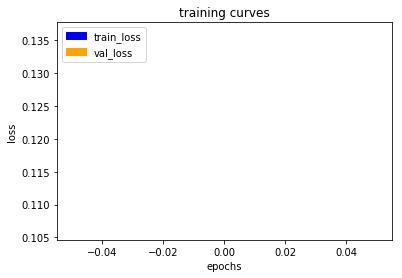

200/200 [==============================] - 185s - loss: 0.1362 - val_loss: 0.1061
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0531

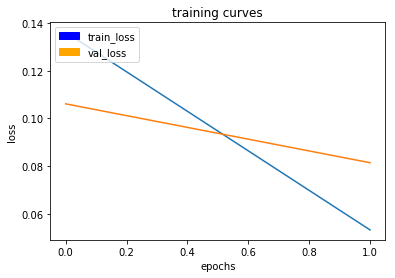

200/200 [==============================] - 182s - loss: 0.0531 - val_loss: 0.0814
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0467

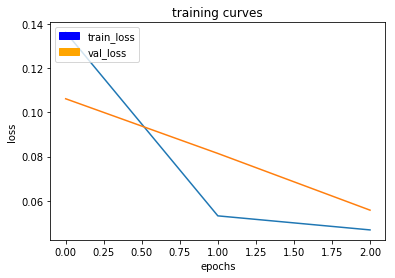

200/200 [==============================] - 180s - loss: 0.0467 - val_loss: 0.0557
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0477

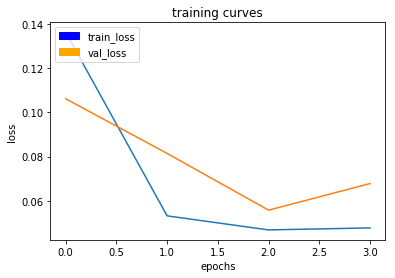

200/200 [==============================] - 181s - loss: 0.0477 - val_loss: 0.0678
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0408

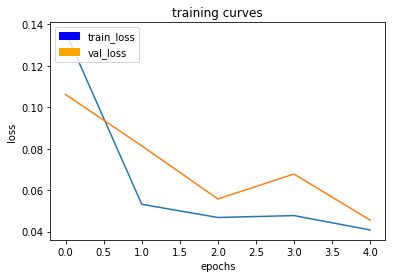

200/200 [==============================] - 181s - loss: 0.0408 - val_loss: 0.0456
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0405

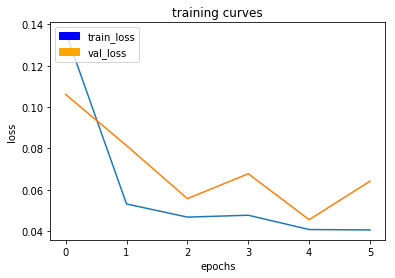

200/200 [==============================] - 183s - loss: 0.0407 - val_loss: 0.0642
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0395

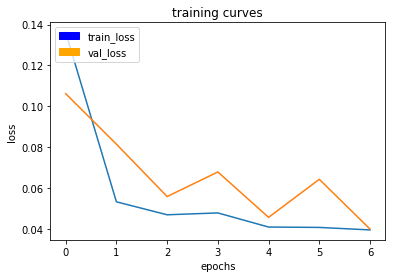

200/200 [==============================] - 186s - loss: 0.0394 - val_loss: 0.0398
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0354

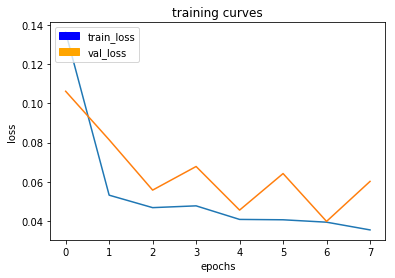

200/200 [==============================] - 184s - loss: 0.0354 - val_loss: 0.0602
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0374

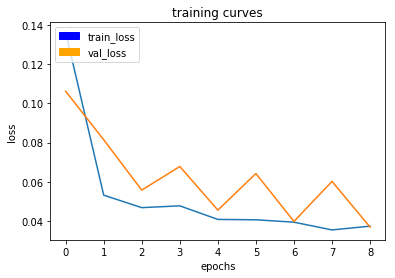

200/200 [==============================] - 187s - loss: 0.0374 - val_loss: 0.0369
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0344

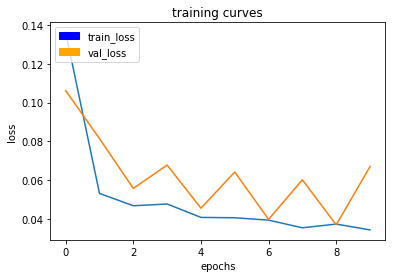

200/200 [==============================] - 192s - loss: 0.0343 - val_loss: 0.0670


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 0.0403

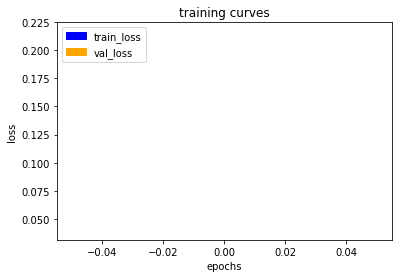

200/200 [==============================] - 194s - loss: 0.0404 - val_loss: 0.2159
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0363

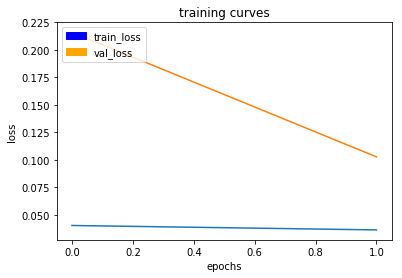

200/200 [==============================] - 190s - loss: 0.0363 - val_loss: 0.1027
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0329

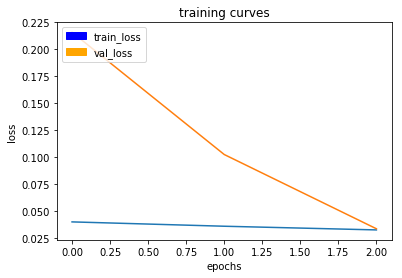

200/200 [==============================] - 187s - loss: 0.0329 - val_loss: 0.0340
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0359

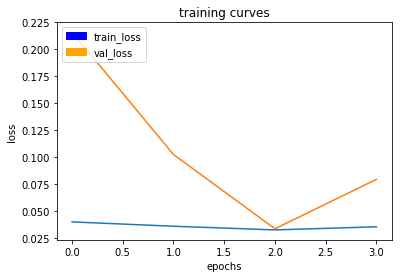

200/200 [==============================] - 186s - loss: 0.0359 - val_loss: 0.0797
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0348

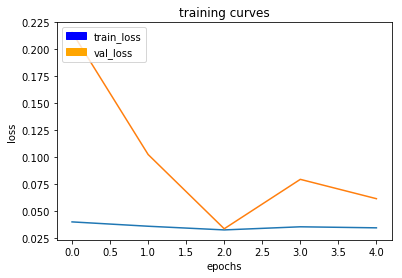

200/200 [==============================] - 193s - loss: 0.0349 - val_loss: 0.0618
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0324

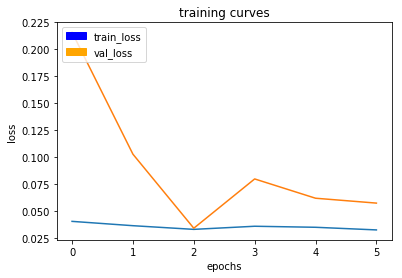

200/200 [==============================] - 185s - loss: 0.0324 - val_loss: 0.0573
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0305

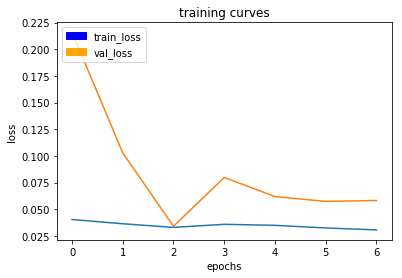

200/200 [==============================] - 184s - loss: 0.0305 - val_loss: 0.0581
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0318

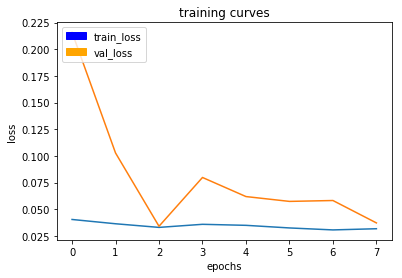

200/200 [==============================] - 186s - loss: 0.0317 - val_loss: 0.0371
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0317

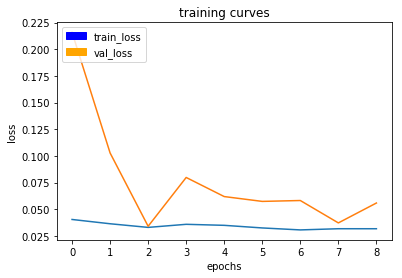

200/200 [==============================] - 188s - loss: 0.0317 - val_loss: 0.0558
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0306

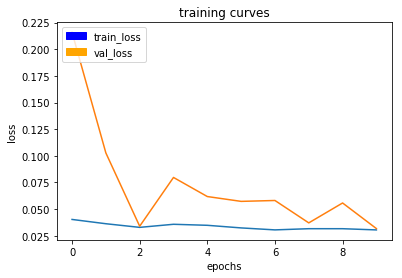

200/200 [==============================] - 186s - loss: 0.0305 - val_loss: 0.0318
run: 2, epochs: 20
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9933169120964531
average intersection over union for other people is 0.2680800706665193
average intersection over union for the hero is 0.7931753781809038
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9755504092808402
average intersection over union for other people is 0.5067492484686278
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 75, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9949666644297275
average intersection over union for other people

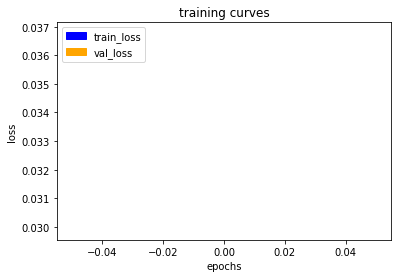

200/200 [==============================] - 187s - loss: 0.0299 - val_loss: 0.0368
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0327

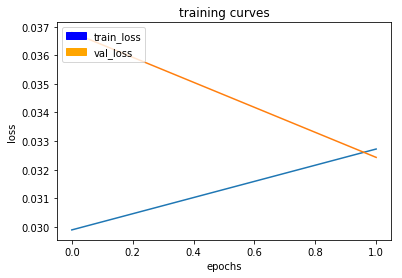

200/200 [==============================] - 180s - loss: 0.0327 - val_loss: 0.0324
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0304

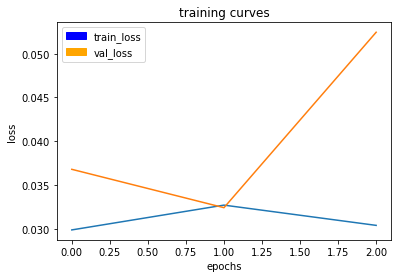

200/200 [==============================] - 182s - loss: 0.0304 - val_loss: 0.0524
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0280

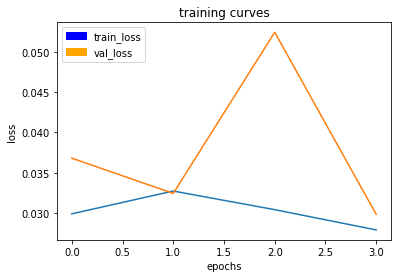

200/200 [==============================] - 180s - loss: 0.0279 - val_loss: 0.0298
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0300

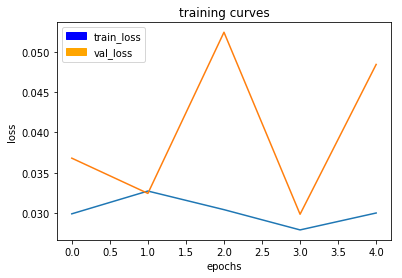

200/200 [==============================] - 181s - loss: 0.0300 - val_loss: 0.0484
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0275

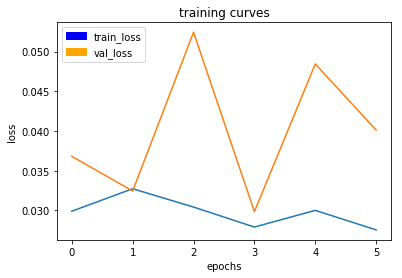

200/200 [==============================] - 180s - loss: 0.0275 - val_loss: 0.0401
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0292

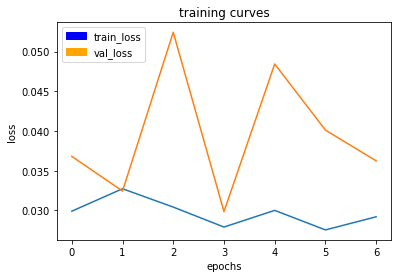

200/200 [==============================] - 180s - loss: 0.0291 - val_loss: 0.0362
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0276

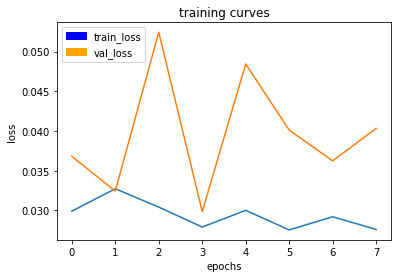

200/200 [==============================] - 180s - loss: 0.0276 - val_loss: 0.0403
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0280

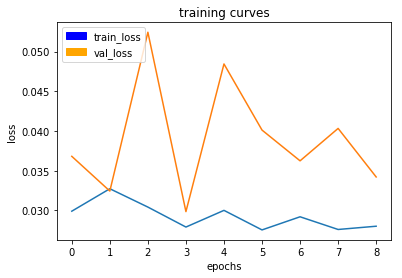

200/200 [==============================] - 181s - loss: 0.0280 - val_loss: 0.0342
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0261

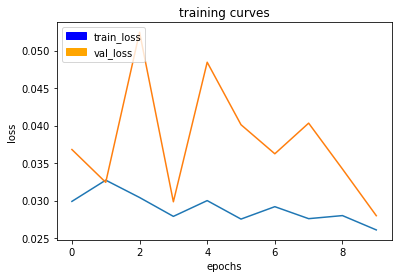

200/200 [==============================] - 180s - loss: 0.0261 - val_loss: 0.0280
run: 3, epochs: 30
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9937558752527075
average intersection over union for other people is 0.3092740841045898
average intersection over union for the hero is 0.8529103905070833
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9771048454006834
average intersection over union for other people is 0.538340587915318
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 85, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9953343500152716
average intersection over union for other people 

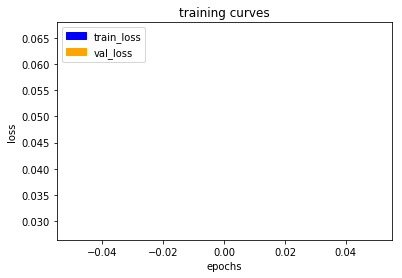

200/200 [==============================] - 182s - loss: 0.0283 - val_loss: 0.0661
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0258

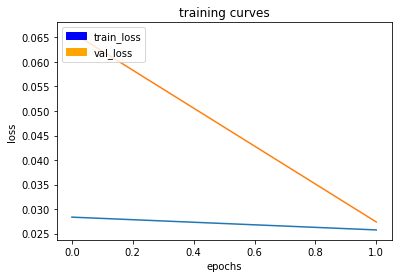

200/200 [==============================] - 180s - loss: 0.0258 - val_loss: 0.0274
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0271

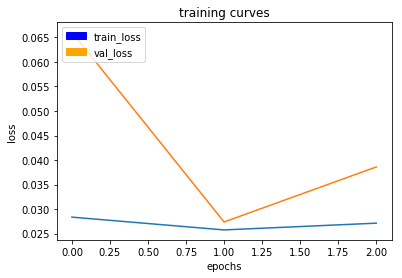

200/200 [==============================] - 180s - loss: 0.0271 - val_loss: 0.0386
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0272

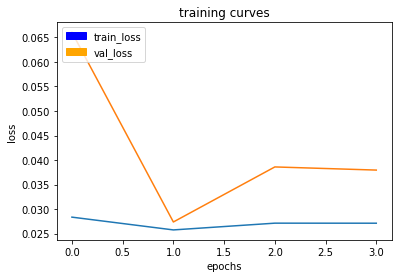

200/200 [==============================] - 180s - loss: 0.0272 - val_loss: 0.0379
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0279

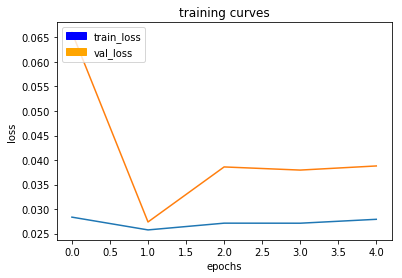

200/200 [==============================] - 181s - loss: 0.0279 - val_loss: 0.0388
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0284

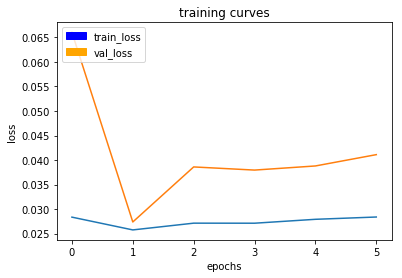

200/200 [==============================] - 180s - loss: 0.0283 - val_loss: 0.0411
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0253

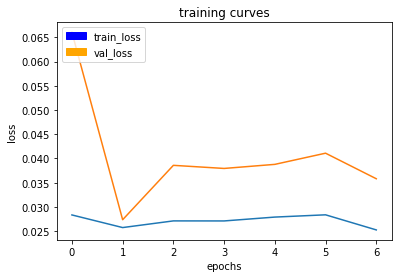

200/200 [==============================] - 180s - loss: 0.0252 - val_loss: 0.0358
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0260

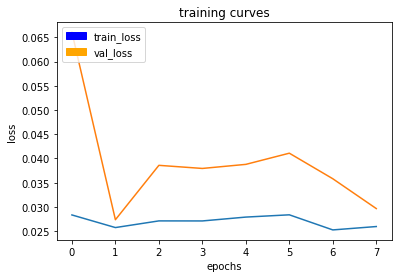

200/200 [==============================] - 180s - loss: 0.0259 - val_loss: 0.0297
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0250

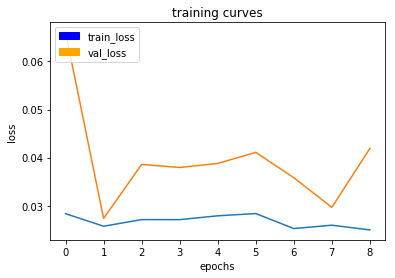

200/200 [==============================] - 181s - loss: 0.0250 - val_loss: 0.0419
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0245

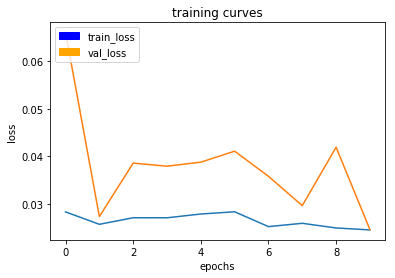

200/200 [==============================] - 180s - loss: 0.0245 - val_loss: 0.0246
run: 4, epochs: 40
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9944227996618612
average intersection over union for other people is 0.3135014152163101
average intersection over union for the hero is 0.871164176106131
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9789316471646152
average intersection over union for other people is 0.5482389059976975
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 132, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954580559003013
average intersection over union for other people

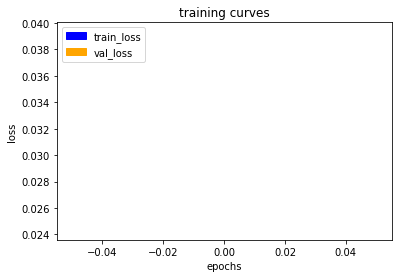

200/200 [==============================] - 182s - loss: 0.0243 - val_loss: 0.0393
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0282

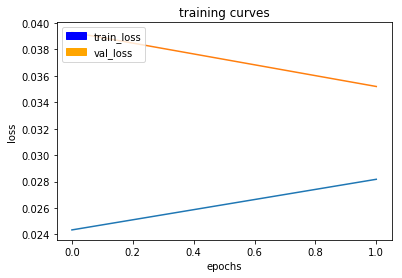

200/200 [==============================] - 180s - loss: 0.0282 - val_loss: 0.0352
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0249

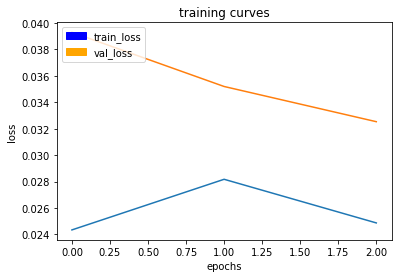

200/200 [==============================] - 180s - loss: 0.0249 - val_loss: 0.0325
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0257

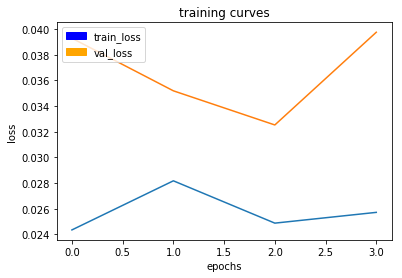

200/200 [==============================] - 180s - loss: 0.0257 - val_loss: 0.0398
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0258

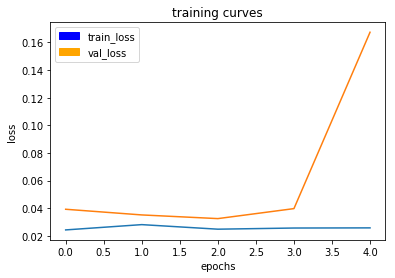

200/200 [==============================] - 181s - loss: 0.0258 - val_loss: 0.1674
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0270

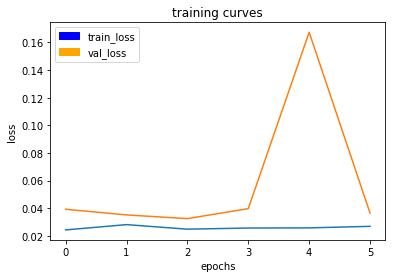

200/200 [==============================] - 180s - loss: 0.0269 - val_loss: 0.0365
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0264

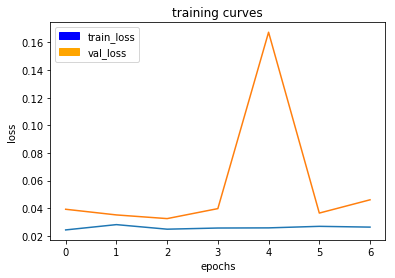

200/200 [==============================] - 180s - loss: 0.0264 - val_loss: 0.0461
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0285

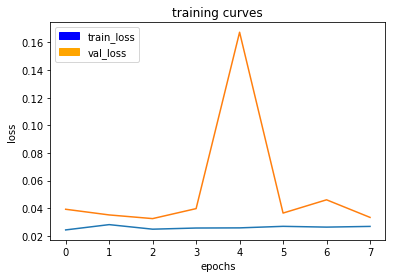

200/200 [==============================] - 180s - loss: 0.0285 - val_loss: 0.0334
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0250

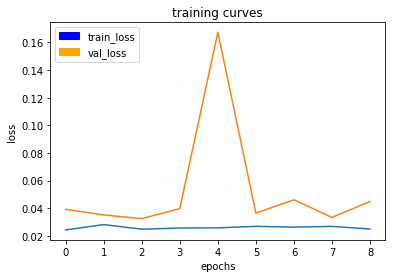

200/200 [==============================] - 181s - loss: 0.0250 - val_loss: 0.0449
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0242

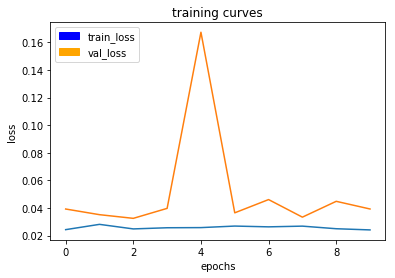

200/200 [==============================] - 180s - loss: 0.0242 - val_loss: 0.0393
run: 5, epochs: 50
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9944078470603682
average intersection over union for other people is 0.2848679936077798
average intersection over union for the hero is 0.8183566834847866
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9818236509789519
average intersection over union for other people is 0.6349909974926655
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 58, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9952103357725094
average intersection over union for other people

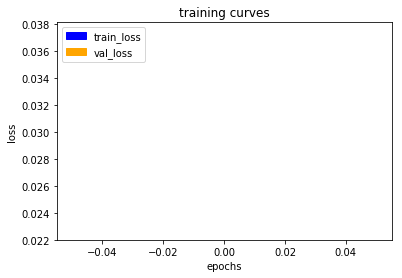

200/200 [==============================] - 182s - loss: 0.0228 - val_loss: 0.0374
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0270

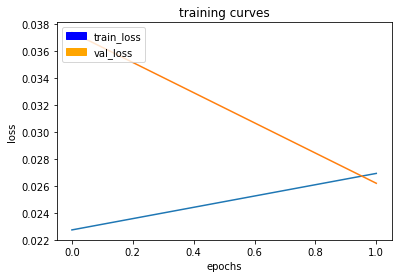

200/200 [==============================] - 181s - loss: 0.0269 - val_loss: 0.0262
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0251

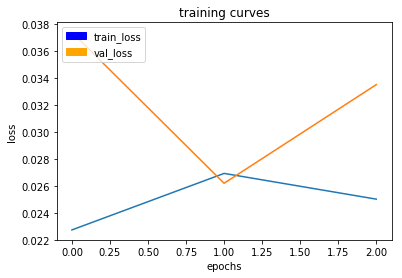

200/200 [==============================] - 181s - loss: 0.0251 - val_loss: 0.0335
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0252

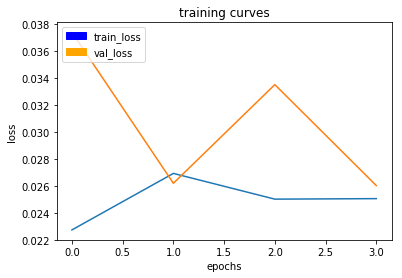

200/200 [==============================] - 181s - loss: 0.0251 - val_loss: 0.0260
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0215

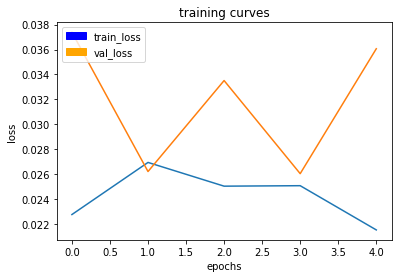

200/200 [==============================] - 182s - loss: 0.0215 - val_loss: 0.0361
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0252

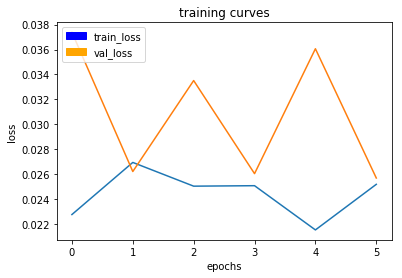

200/200 [==============================] - 181s - loss: 0.0251 - val_loss: 0.0257
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0261

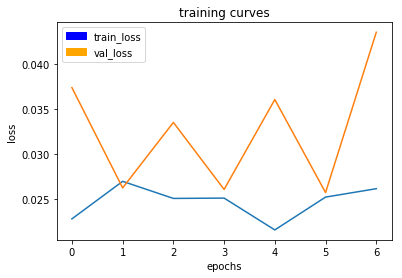

200/200 [==============================] - 181s - loss: 0.0261 - val_loss: 0.0436
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0252

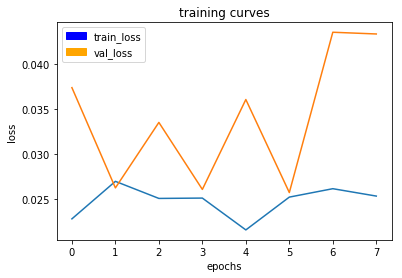

200/200 [==============================] - 181s - loss: 0.0252 - val_loss: 0.0434
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0233

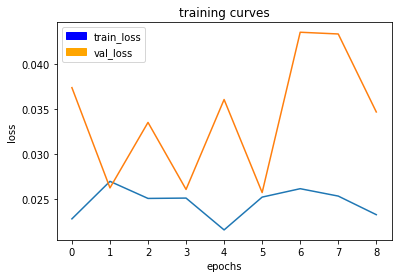

200/200 [==============================] - 181s - loss: 0.0232 - val_loss: 0.0347
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0242

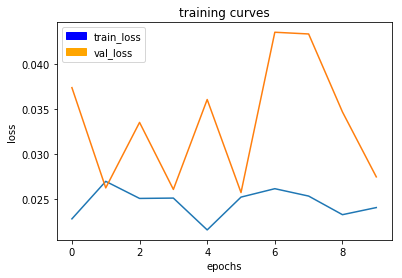

200/200 [==============================] - 181s - loss: 0.0241 - val_loss: 0.0274
run: 6, epochs: 60
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9947192307565326
average intersection over union for other people is 0.2886078294915012
average intersection over union for the hero is 0.8753316284842133
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9780933853750673
average intersection over union for other people is 0.5391546256878471
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 100, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.995497246701491
average intersection over union for other people

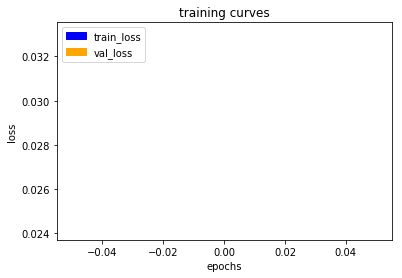

200/200 [==============================] - 182s - loss: 0.0242 - val_loss: 0.0331
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0232

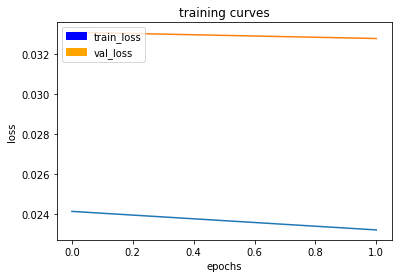

200/200 [==============================] - 180s - loss: 0.0232 - val_loss: 0.0328
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0254

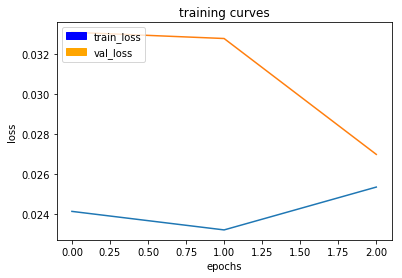

200/200 [==============================] - 181s - loss: 0.0253 - val_loss: 0.0270
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0214

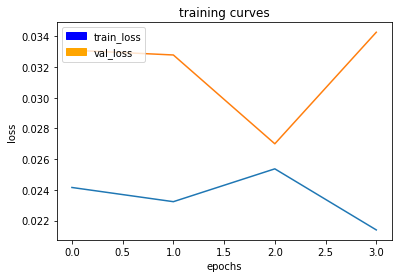

200/200 [==============================] - 180s - loss: 0.0214 - val_loss: 0.0343
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0240

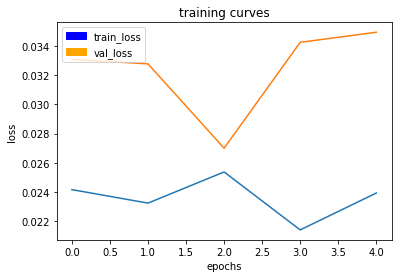

200/200 [==============================] - 181s - loss: 0.0239 - val_loss: 0.0350
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0237

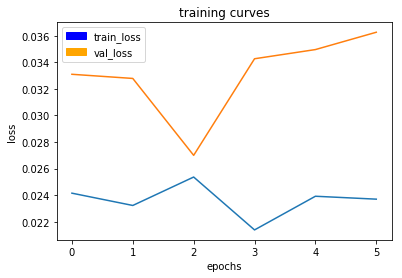

200/200 [==============================] - 180s - loss: 0.0237 - val_loss: 0.0363
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0239

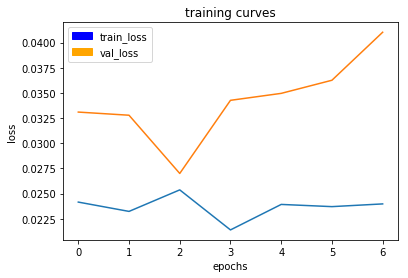

200/200 [==============================] - 180s - loss: 0.0239 - val_loss: 0.0410
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0245

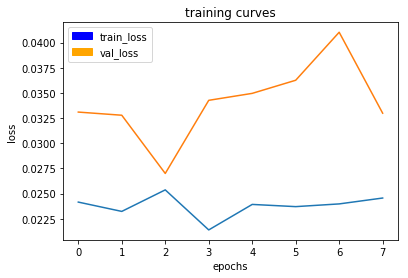

200/200 [==============================] - 180s - loss: 0.0245 - val_loss: 0.0330
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0244

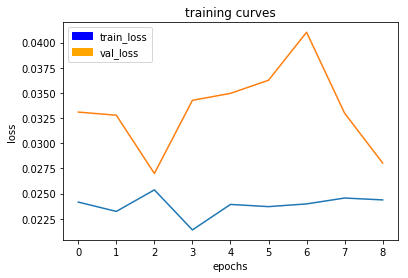

200/200 [==============================] - 181s - loss: 0.0244 - val_loss: 0.0280
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0221

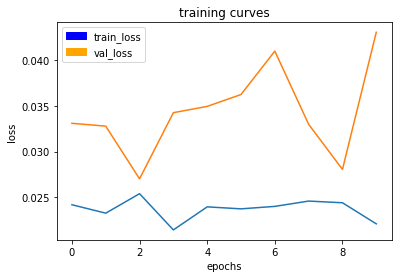

200/200 [==============================] - 180s - loss: 0.0220 - val_loss: 0.0431
run: 7, epochs: 70
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9947372897817104
average intersection over union for other people is 0.3202127543579673
average intersection over union for the hero is 0.8483712613483029
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9826959182255427
average intersection over union for other people is 0.640134591133076
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 84, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954300268473293
average intersection over union for other people 

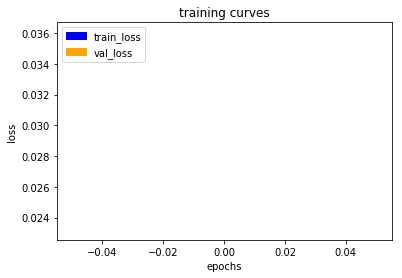

200/200 [==============================] - 182s - loss: 0.0232 - val_loss: 0.0361
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0231

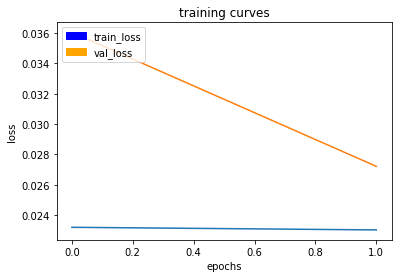

200/200 [==============================] - 181s - loss: 0.0230 - val_loss: 0.0272
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0254

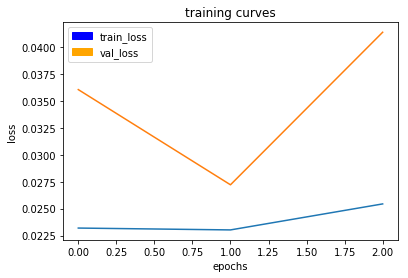

200/200 [==============================] - 181s - loss: 0.0254 - val_loss: 0.0414
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

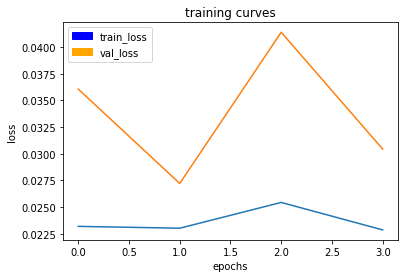

200/200 [==============================] - 180s - loss: 0.0229 - val_loss: 0.0304
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0208

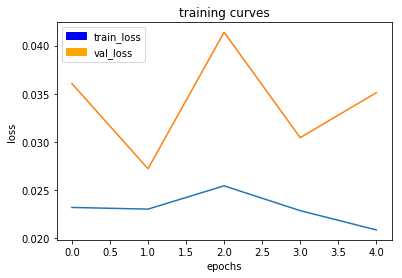

200/200 [==============================] - 181s - loss: 0.0209 - val_loss: 0.0351
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0261

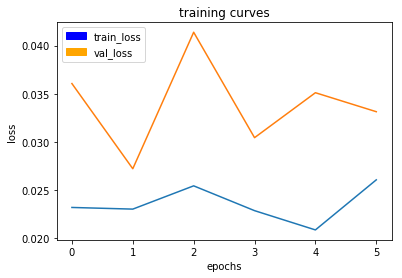

200/200 [==============================] - 181s - loss: 0.0260 - val_loss: 0.0331
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0225

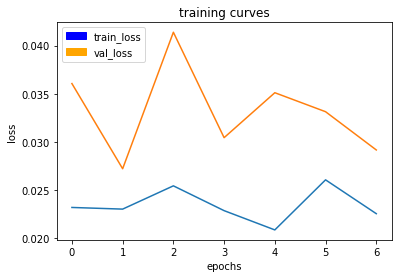

200/200 [==============================] - 180s - loss: 0.0225 - val_loss: 0.0292
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0237

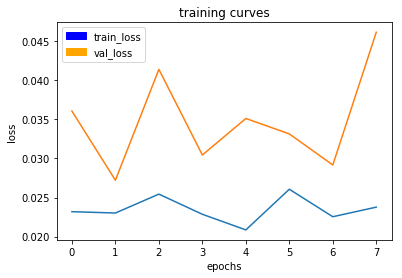

200/200 [==============================] - 180s - loss: 0.0237 - val_loss: 0.0461
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0222

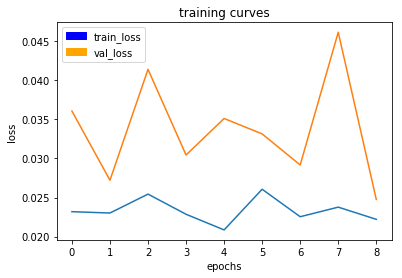

200/200 [==============================] - 181s - loss: 0.0222 - val_loss: 0.0248
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0226

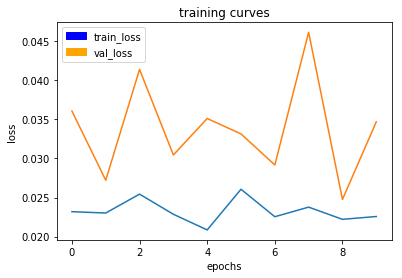

200/200 [==============================] - 181s - loss: 0.0226 - val_loss: 0.0347
run: 8, epochs: 80
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9944099595227888
average intersection over union for other people is 0.30204714648821823
average intersection over union for the hero is 0.8549195366054256
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9828048033120659
average intersection over union for other people is 0.6580002053843418
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 74, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9949532177989036
average intersection over union for other peopl

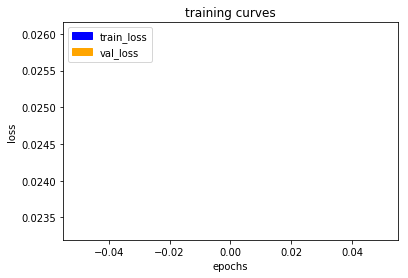

200/200 [==============================] - 182s - loss: 0.0233 - val_loss: 0.0260
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

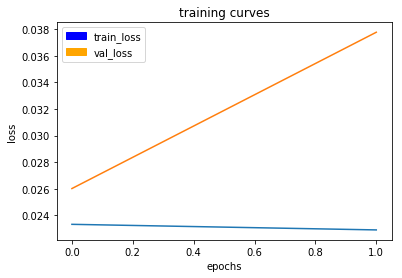

200/200 [==============================] - 181s - loss: 0.0229 - val_loss: 0.0378
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0212

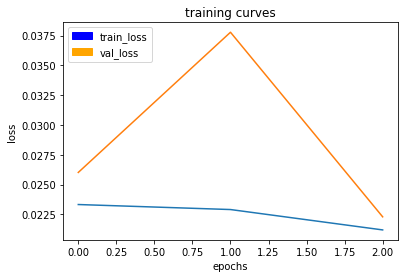

200/200 [==============================] - 180s - loss: 0.0212 - val_loss: 0.0223
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0240

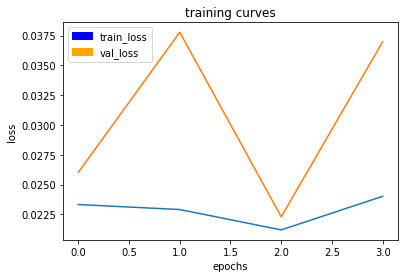

200/200 [==============================] - 180s - loss: 0.0240 - val_loss: 0.0370
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0227

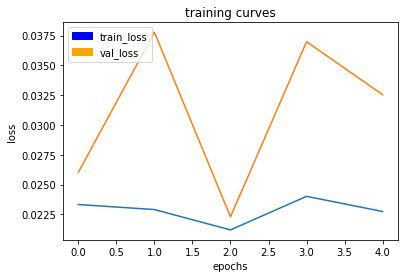

200/200 [==============================] - 181s - loss: 0.0227 - val_loss: 0.0325
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0215

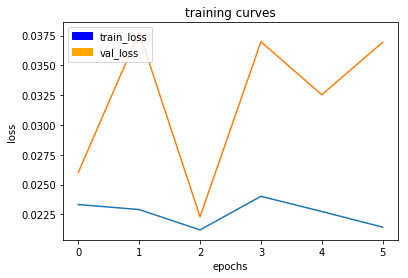

200/200 [==============================] - 180s - loss: 0.0215 - val_loss: 0.0369
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0247

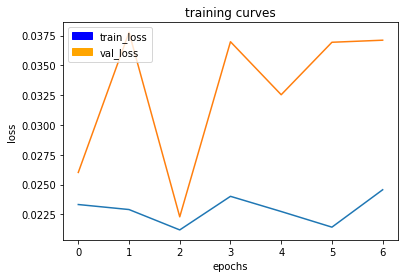

200/200 [==============================] - 181s - loss: 0.0247 - val_loss: 0.0371
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

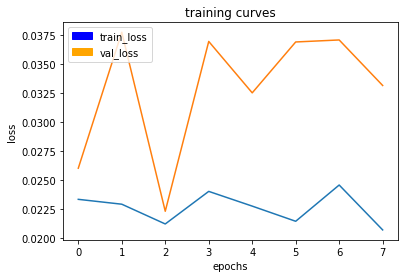

200/200 [==============================] - 180s - loss: 0.0207 - val_loss: 0.0332
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0220

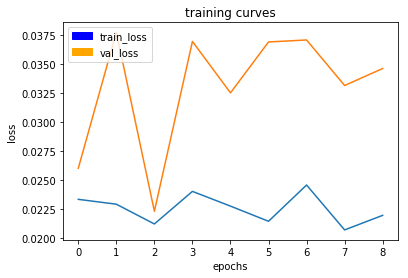

200/200 [==============================] - 181s - loss: 0.0219 - val_loss: 0.0346
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0239

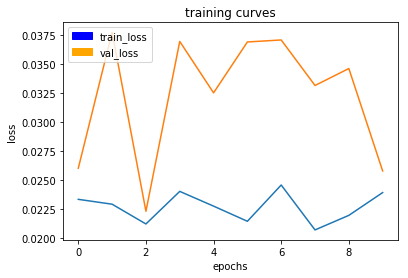

200/200 [==============================] - 180s - loss: 0.0239 - val_loss: 0.0258
run: 9, epochs: 90
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9950876318323879
average intersection over union for other people is 0.3218599956502944
average intersection over union for the hero is 0.86526175214799
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.982580235774557
average intersection over union for other people is 0.6364150146225952
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 79, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959102513070061
average intersection over union for other people is

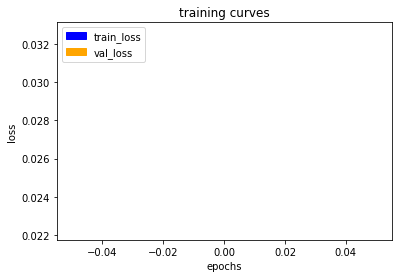

200/200 [==============================] - 182s - loss: 0.0223 - val_loss: 0.0326
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0217

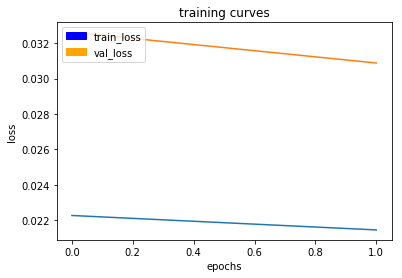

200/200 [==============================] - 180s - loss: 0.0216 - val_loss: 0.0309
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0231

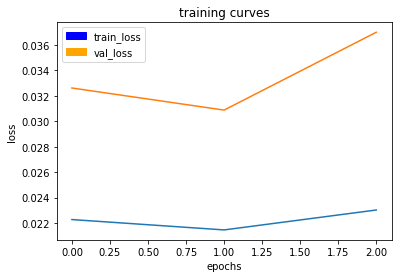

200/200 [==============================] - 180s - loss: 0.0230 - val_loss: 0.0370
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0228

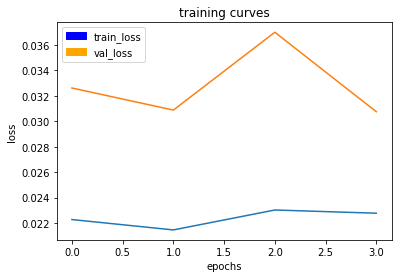

200/200 [==============================] - 180s - loss: 0.0228 - val_loss: 0.0308
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0222

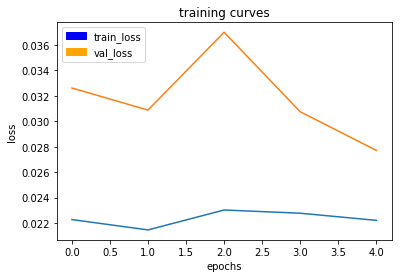

200/200 [==============================] - 181s - loss: 0.0222 - val_loss: 0.0277
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0232

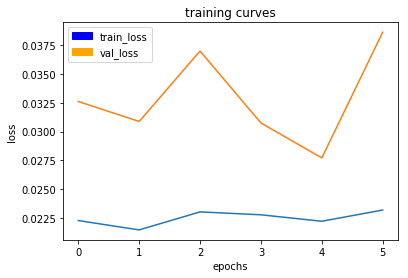

200/200 [==============================] - 180s - loss: 0.0232 - val_loss: 0.0386
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

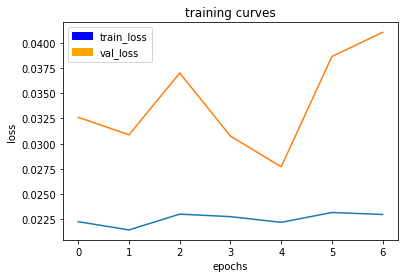

200/200 [==============================] - 180s - loss: 0.0229 - val_loss: 0.0411
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0220

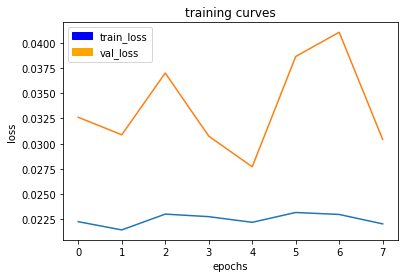

200/200 [==============================] - 180s - loss: 0.0220 - val_loss: 0.0304
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

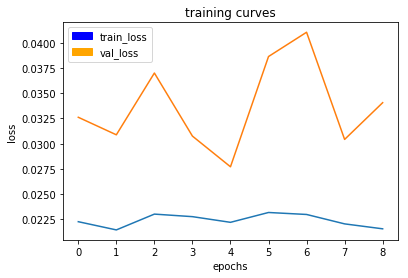

200/200 [==============================] - 181s - loss: 0.0216 - val_loss: 0.0341
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0218

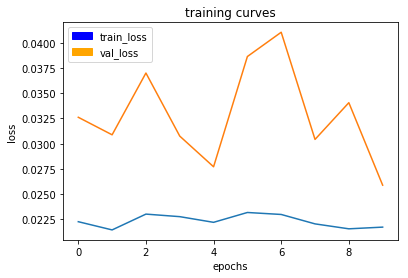

200/200 [==============================] - 180s - loss: 0.0218 - val_loss: 0.0259
run: 10, epochs: 100
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954223027674117
average intersection over union for other people is 0.3332663340170551
average intersection over union for the hero is 0.8811453960252684
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.98383256984286
average intersection over union for other people is 0.6629520597902508
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 85, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.996046965938289
average intersection over union for other people 

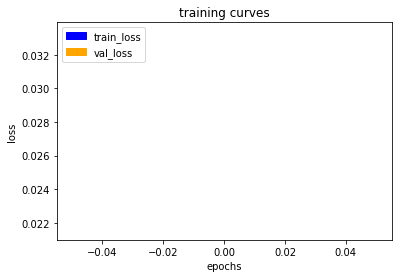

200/200 [==============================] - 182s - loss: 0.0216 - val_loss: 0.0333
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0226

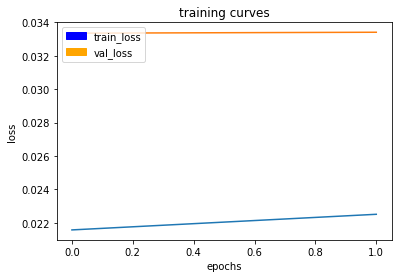

200/200 [==============================] - 180s - loss: 0.0226 - val_loss: 0.0334
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0200

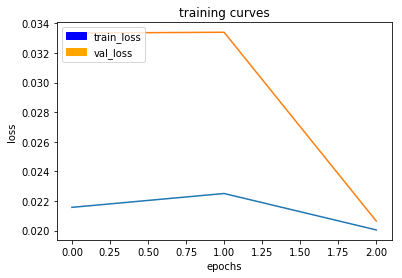

200/200 [==============================] - 180s - loss: 0.0200 - val_loss: 0.0206
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

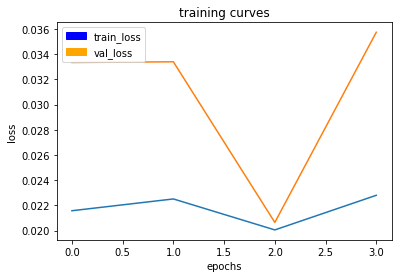

200/200 [==============================] - 180s - loss: 0.0228 - val_loss: 0.0358
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

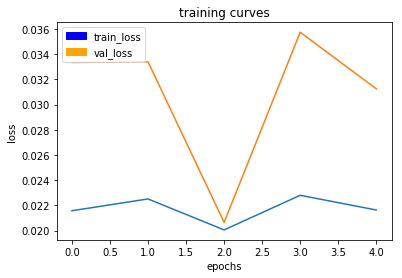

200/200 [==============================] - 181s - loss: 0.0216 - val_loss: 0.0313
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0360

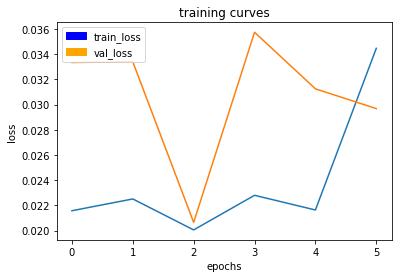

200/200 [==============================] - 180s - loss: 0.0359 - val_loss: 0.0297
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0228

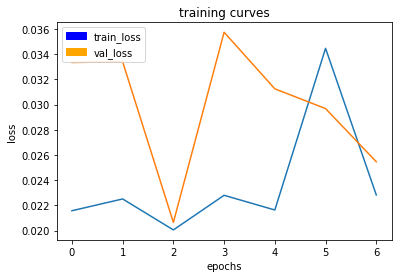

200/200 [==============================] - 180s - loss: 0.0228 - val_loss: 0.0255
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0222

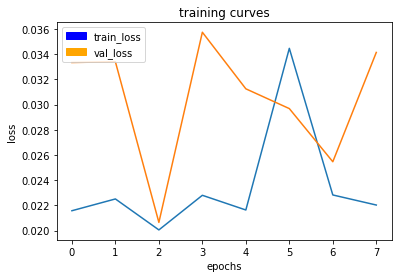

200/200 [==============================] - 180s - loss: 0.0221 - val_loss: 0.0341
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

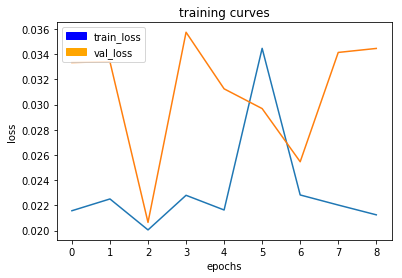

200/200 [==============================] - 181s - loss: 0.0212 - val_loss: 0.0345
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0225

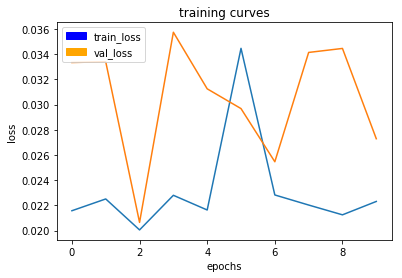

200/200 [==============================] - 180s - loss: 0.0225 - val_loss: 0.0273
run: 11, epochs: 110
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951904127918245
average intersection over union for other people is 0.3286503374314764
average intersection over union for the hero is 0.8863150625007604
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9821418007828991
average intersection over union for other people is 0.6339177425435143
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 95, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.995958102203017
average intersection over union for other peopl

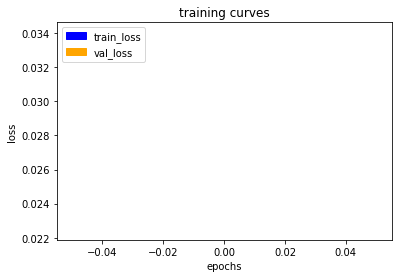

200/200 [==============================] - 182s - loss: 0.0225 - val_loss: 0.0341
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0200

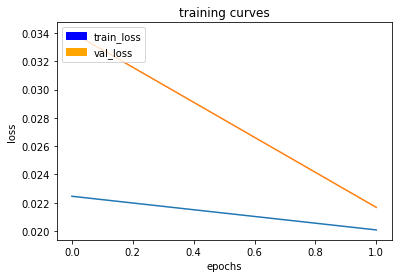

200/200 [==============================] - 180s - loss: 0.0200 - val_loss: 0.0217
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0231

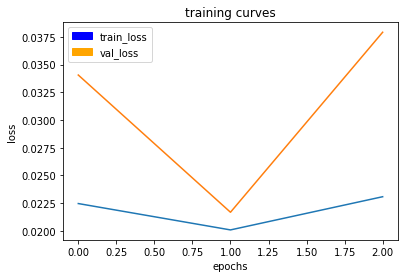

200/200 [==============================] - 180s - loss: 0.0231 - val_loss: 0.0379
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0224

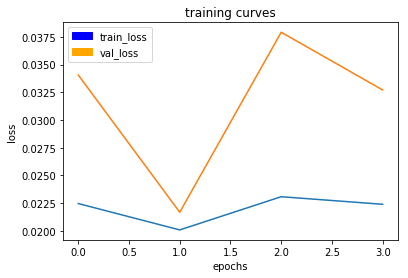

200/200 [==============================] - 180s - loss: 0.0224 - val_loss: 0.0327
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0212

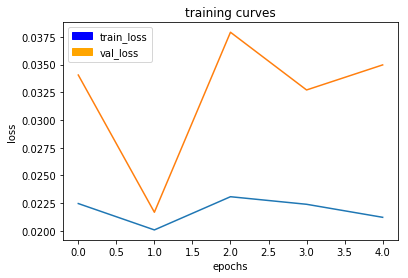

200/200 [==============================] - 181s - loss: 0.0212 - val_loss: 0.0350
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

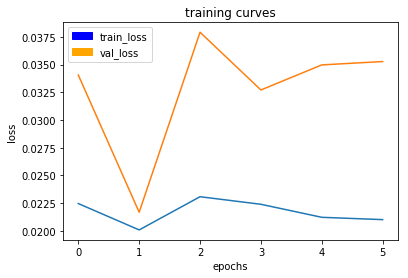

200/200 [==============================] - 180s - loss: 0.0211 - val_loss: 0.0353
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0208

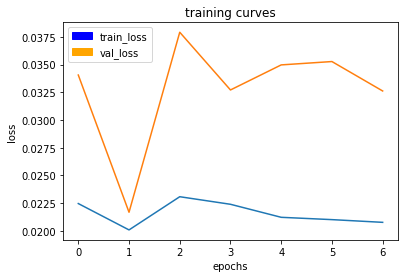

200/200 [==============================] - 180s - loss: 0.0208 - val_loss: 0.0326
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

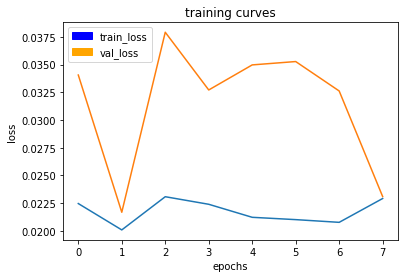

200/200 [==============================] - 180s - loss: 0.0229 - val_loss: 0.0231
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0210

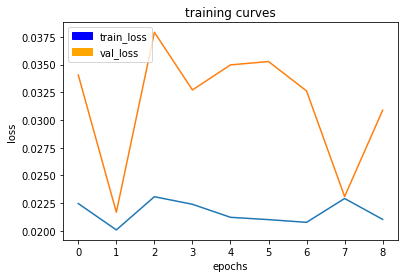

200/200 [==============================] - 181s - loss: 0.0210 - val_loss: 0.0309
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

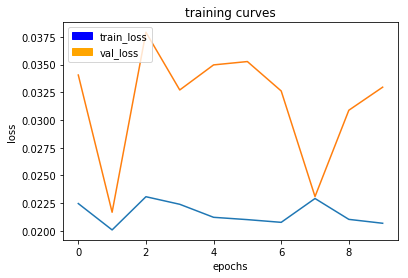

200/200 [==============================] - 180s - loss: 0.0207 - val_loss: 0.0330
run: 12, epochs: 120
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9947993370777803
average intersection over union for other people is 0.30945384398233894
average intersection over union for the hero is 0.8496780178272316
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9786619580790112
average intersection over union for other people is 0.5709565321337825
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 62, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954859493249079
average intersection over union for other peo

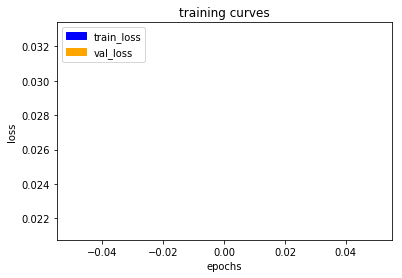

200/200 [==============================] - 183s - loss: 0.0213 - val_loss: 0.0328
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

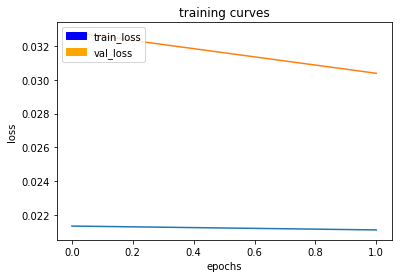

200/200 [==============================] - 180s - loss: 0.0211 - val_loss: 0.0304
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0205

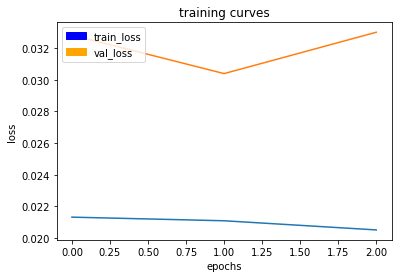

200/200 [==============================] - 180s - loss: 0.0205 - val_loss: 0.0330
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0229

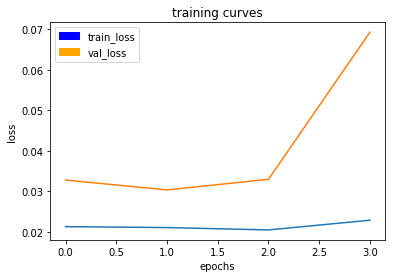

200/200 [==============================] - 180s - loss: 0.0229 - val_loss: 0.0693
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0210

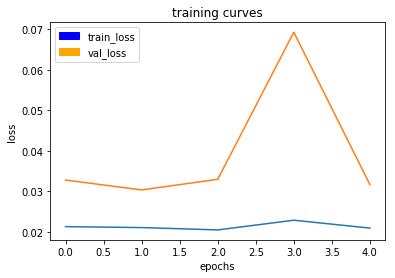

200/200 [==============================] - 181s - loss: 0.0210 - val_loss: 0.0317
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0217

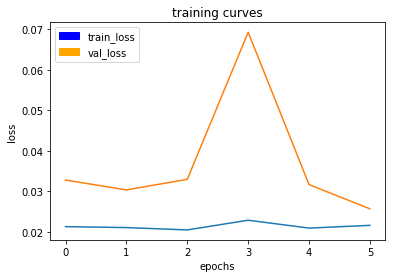

200/200 [==============================] - 181s - loss: 0.0216 - val_loss: 0.0257
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0199

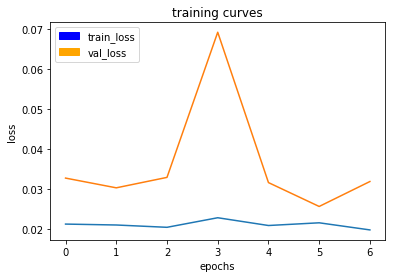

200/200 [==============================] - 180s - loss: 0.0199 - val_loss: 0.0320
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0214

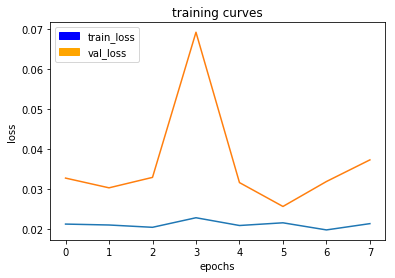

200/200 [==============================] - 180s - loss: 0.0214 - val_loss: 0.0374
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

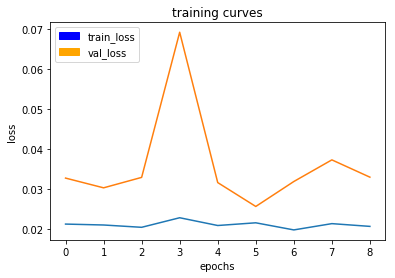

200/200 [==============================] - 181s - loss: 0.0207 - val_loss: 0.0331
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0222

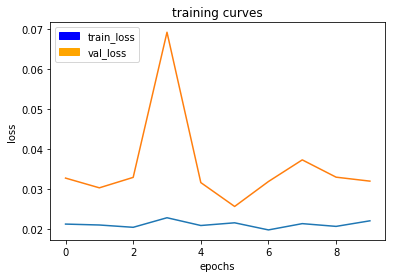

200/200 [==============================] - 180s - loss: 0.0222 - val_loss: 0.0321
run: 13, epochs: 130
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9946091395416143
average intersection over union for other people is 0.3023255797928908
average intersection over union for the hero is 0.868257280428389
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9788598721064667
average intersection over union for other people is 0.557836860947609
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 114, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9955308241180281
average intersection over union for other peopl

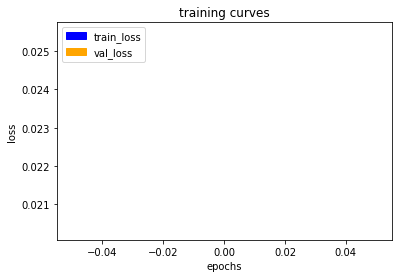

200/200 [==============================] - 183s - loss: 0.0203 - val_loss: 0.0255
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0230

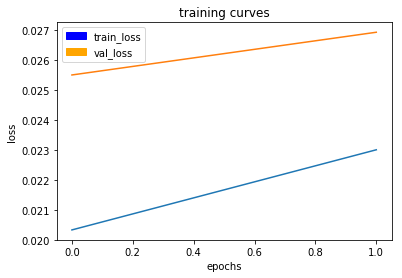

200/200 [==============================] - 180s - loss: 0.0230 - val_loss: 0.0269
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

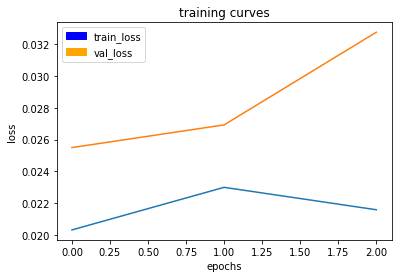

200/200 [==============================] - 180s - loss: 0.0216 - val_loss: 0.0327
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0197

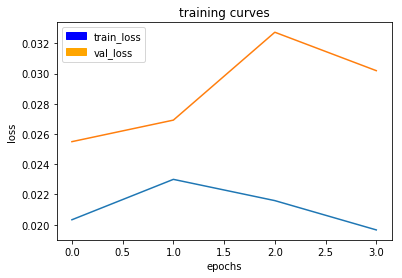

200/200 [==============================] - 181s - loss: 0.0197 - val_loss: 0.0302
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0213

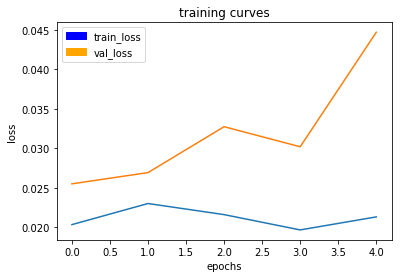

200/200 [==============================] - 181s - loss: 0.0213 - val_loss: 0.0447
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0223

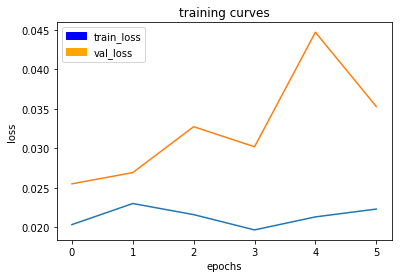

200/200 [==============================] - 180s - loss: 0.0223 - val_loss: 0.0353
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

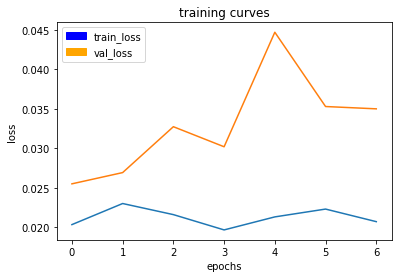

200/200 [==============================] - 180s - loss: 0.0207 - val_loss: 0.0350
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

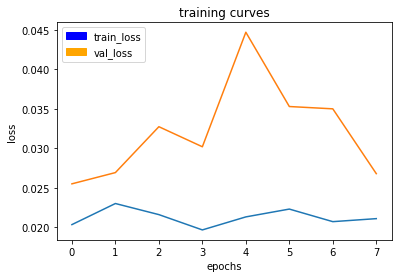

200/200 [==============================] - 181s - loss: 0.0211 - val_loss: 0.0268
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0197

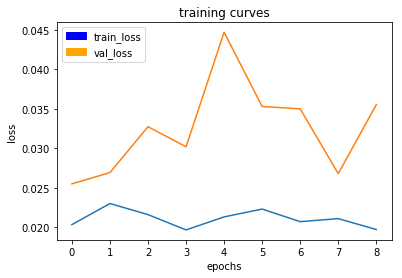

200/200 [==============================] - 181s - loss: 0.0197 - val_loss: 0.0355
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0204

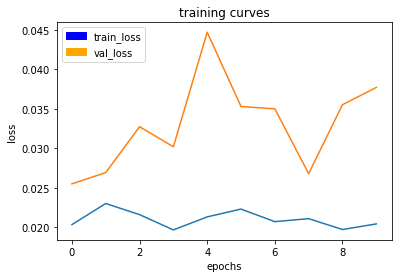

200/200 [==============================] - 180s - loss: 0.0204 - val_loss: 0.0377
run: 14, epochs: 140
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9948874958380318
average intersection over union for other people is 0.3328400863713416
average intersection over union for the hero is 0.875372571457305
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9807666078649798
average intersection over union for other people is 0.6131793106037237
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 96, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954334703069097
average intersection over union for other peopl

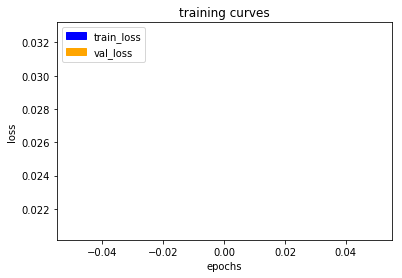

200/200 [==============================] - 183s - loss: 0.0207 - val_loss: 0.0326
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0194

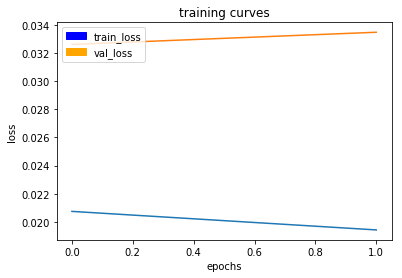

200/200 [==============================] - 180s - loss: 0.0194 - val_loss: 0.0335
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0209

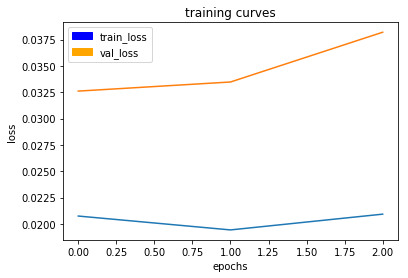

200/200 [==============================] - 181s - loss: 0.0209 - val_loss: 0.0382
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0228

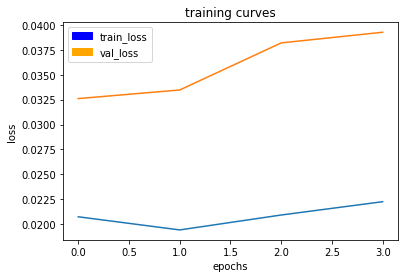

200/200 [==============================] - 180s - loss: 0.0228 - val_loss: 0.0393
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0230

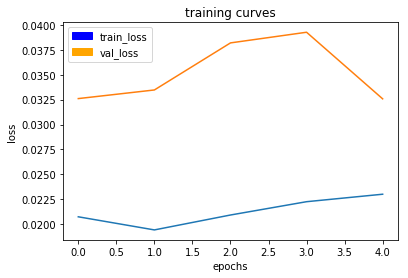

200/200 [==============================] - 181s - loss: 0.0230 - val_loss: 0.0326
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0201

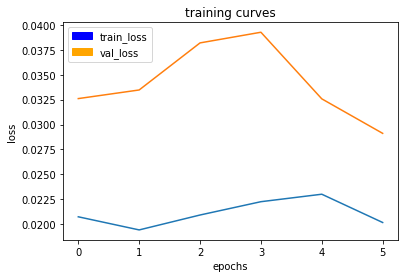

200/200 [==============================] - 180s - loss: 0.0201 - val_loss: 0.0291
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0222

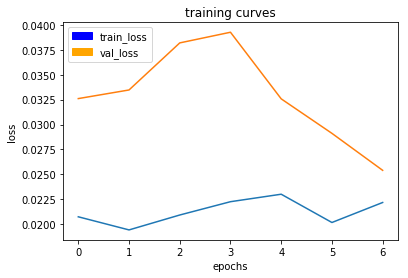

200/200 [==============================] - 180s - loss: 0.0222 - val_loss: 0.0254
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0217

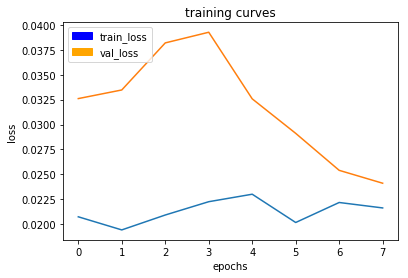

200/200 [==============================] - 180s - loss: 0.0217 - val_loss: 0.0241
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

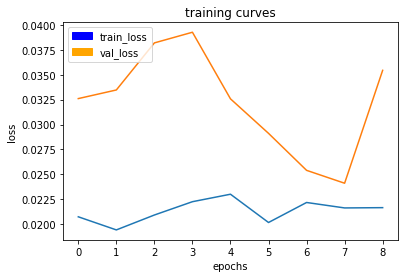

200/200 [==============================] - 181s - loss: 0.0217 - val_loss: 0.0354
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0208

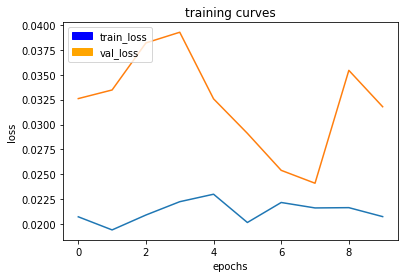

200/200 [==============================] - 180s - loss: 0.0208 - val_loss: 0.0318
run: 15, epochs: 150
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9952839306002033
average intersection over union for other people is 0.33832397938507736
average intersection over union for the hero is 0.8804956587305082
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.984884313192766
average intersection over union for other people is 0.6867917419323206
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 100, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.995785920482122
average intersection over union for other peop

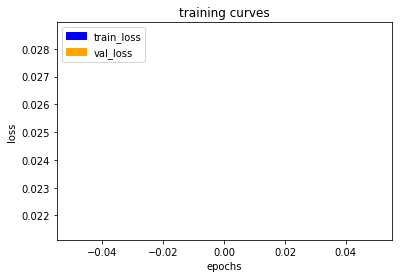

200/200 [==============================] - 183s - loss: 0.0215 - val_loss: 0.0286
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0214

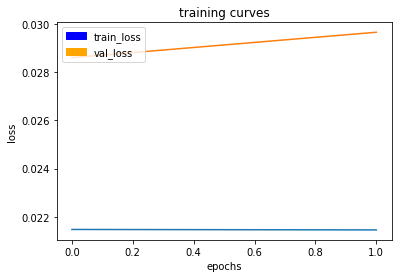

200/200 [==============================] - 180s - loss: 0.0214 - val_loss: 0.0296
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

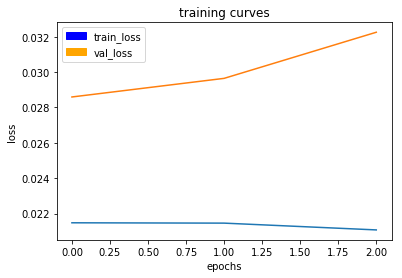

200/200 [==============================] - 180s - loss: 0.0211 - val_loss: 0.0323
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0199

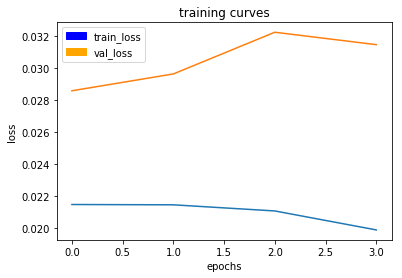

200/200 [==============================] - 180s - loss: 0.0199 - val_loss: 0.0315
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0214

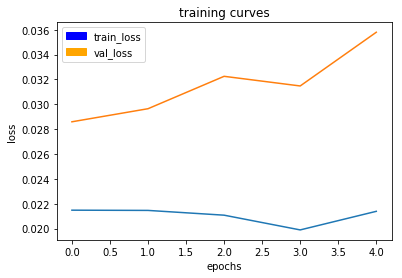

200/200 [==============================] - 181s - loss: 0.0214 - val_loss: 0.0358
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0195

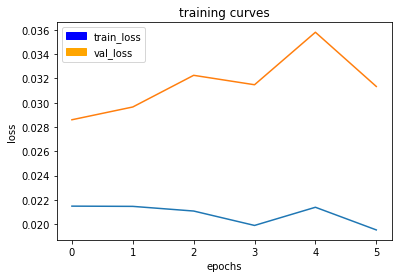

200/200 [==============================] - 180s - loss: 0.0195 - val_loss: 0.0313
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0226

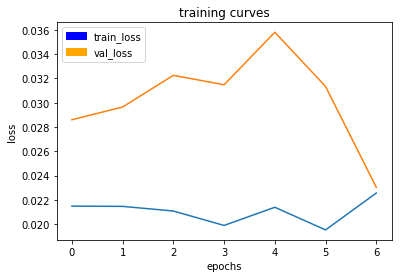

200/200 [==============================] - 180s - loss: 0.0226 - val_loss: 0.0230
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

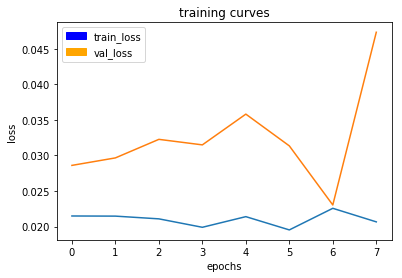

200/200 [==============================] - 180s - loss: 0.0207 - val_loss: 0.0473
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0214

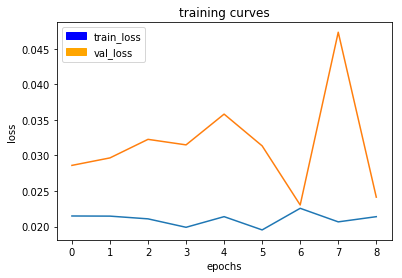

200/200 [==============================] - 181s - loss: 0.0214 - val_loss: 0.0241
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0209

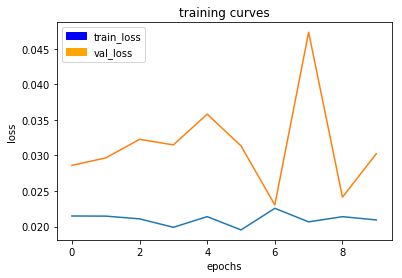

200/200 [==============================] - 180s - loss: 0.0209 - val_loss: 0.0302
run: 16, epochs: 160
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9953631223971097
average intersection over union for other people is 0.32120559601974785
average intersection over union for the hero is 0.8581361942866429
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9837511802051474
average intersection over union for other people is 0.6640624679859741
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960037584514537
average intersection over union for other peo

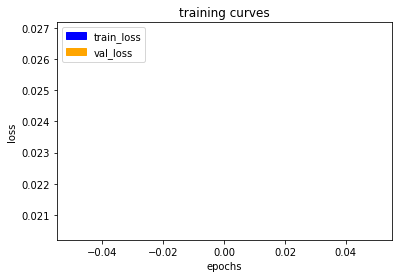

200/200 [==============================] - 183s - loss: 0.0205 - val_loss: 0.0269
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0197

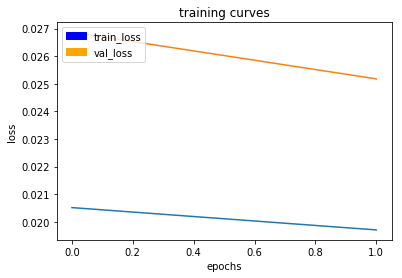

200/200 [==============================] - 181s - loss: 0.0197 - val_loss: 0.0252
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0219

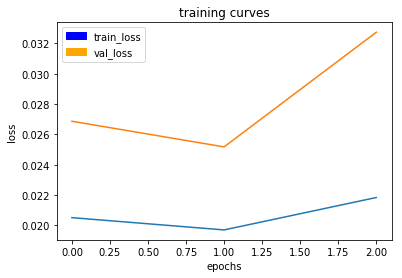

200/200 [==============================] - 180s - loss: 0.0218 - val_loss: 0.0327
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0205

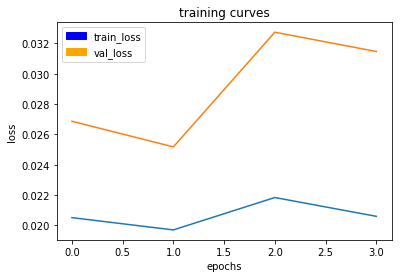

200/200 [==============================] - 181s - loss: 0.0205 - val_loss: 0.0315
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0218

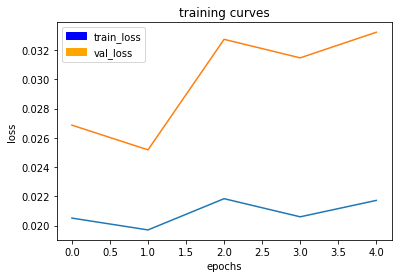

200/200 [==============================] - 183s - loss: 0.0217 - val_loss: 0.0332
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0204

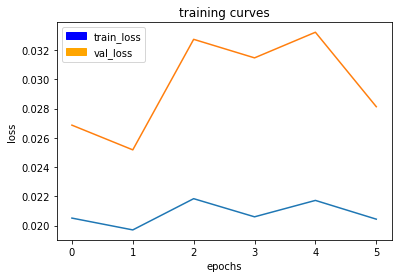

200/200 [==============================] - 182s - loss: 0.0204 - val_loss: 0.0281
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0201

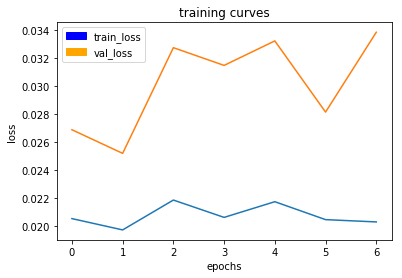

200/200 [==============================] - 182s - loss: 0.0204 - val_loss: 0.0338
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

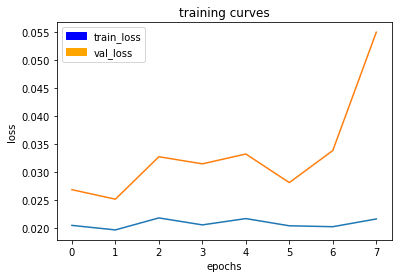

200/200 [==============================] - 185s - loss: 0.0216 - val_loss: 0.0549
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0208

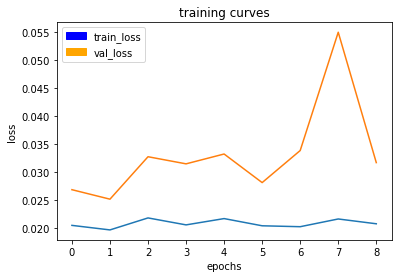

200/200 [==============================] - 186s - loss: 0.0208 - val_loss: 0.0317
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0198

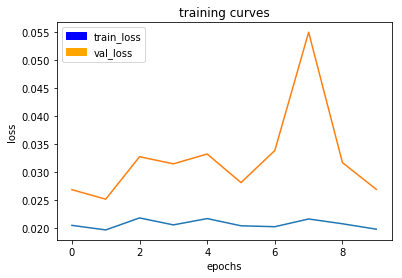

200/200 [==============================] - 182s - loss: 0.0198 - val_loss: 0.0269
run: 17, epochs: 170
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951736350834728
average intersection over union for other people is 0.3423225568318217
average intersection over union for the hero is 0.8882970543968213
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9859793792054555
average intersection over union for other people is 0.7194476824354911
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 86, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9956636801553563
average intersection over union for other peop

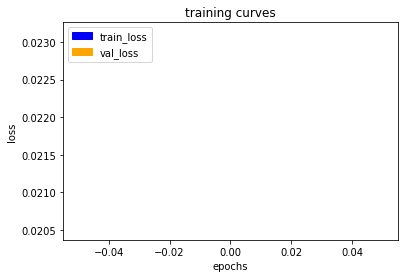

200/200 [==============================] - 186s - loss: 0.0205 - val_loss: 0.0231
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0198

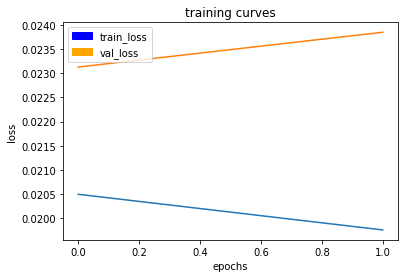

200/200 [==============================] - 182s - loss: 0.0197 - val_loss: 0.0238
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0226

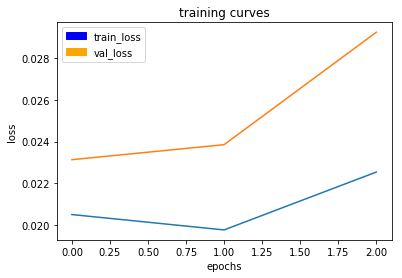

200/200 [==============================] - 181s - loss: 0.0225 - val_loss: 0.0292
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0200

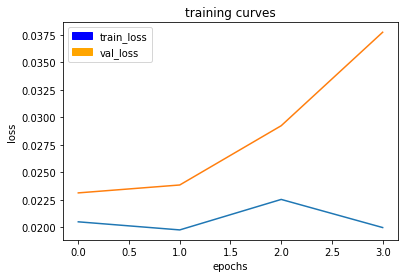

200/200 [==============================] - 182s - loss: 0.0200 - val_loss: 0.0377
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0216

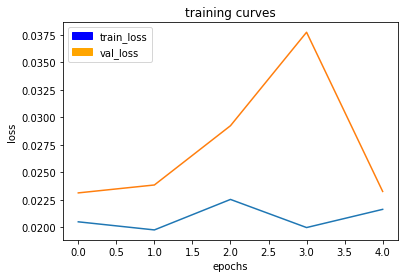

200/200 [==============================] - 181s - loss: 0.0216 - val_loss: 0.0233
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0209

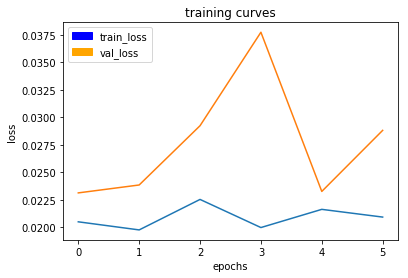

200/200 [==============================] - 181s - loss: 0.0209 - val_loss: 0.0288
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0182

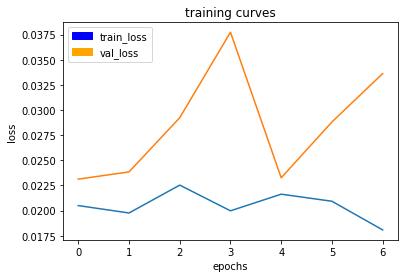

200/200 [==============================] - 181s - loss: 0.0182 - val_loss: 0.0336
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0204

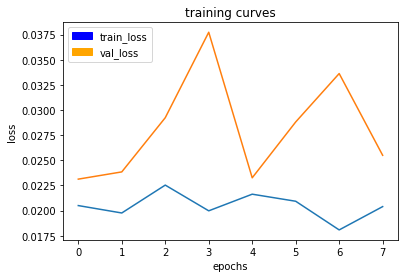

200/200 [==============================] - 181s - loss: 0.0204 - val_loss: 0.0255
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0217

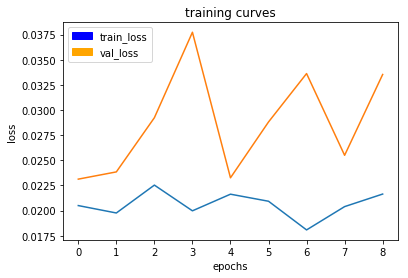

200/200 [==============================] - 181s - loss: 0.0216 - val_loss: 0.0335
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

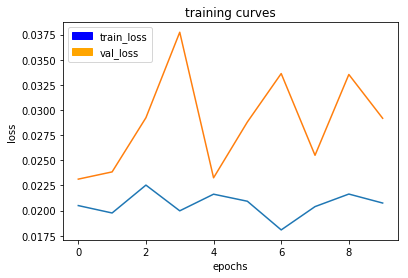

200/200 [==============================] - 181s - loss: 0.0207 - val_loss: 0.0292
run: 18, epochs: 180
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9932293170789585
average intersection over union for other people is 0.31992094796854303
average intersection over union for the hero is 0.8366334507579015
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.984156611949021
average intersection over union for other people is 0.6884813338417892
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 83, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9938658595508643
average intersection over union for other peop

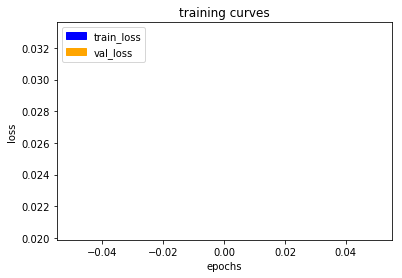

200/200 [==============================] - 183s - loss: 0.0205 - val_loss: 0.0330
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0188

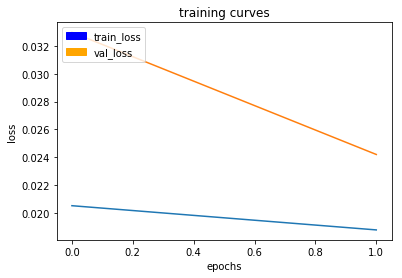

200/200 [==============================] - 181s - loss: 0.0187 - val_loss: 0.0242
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0238

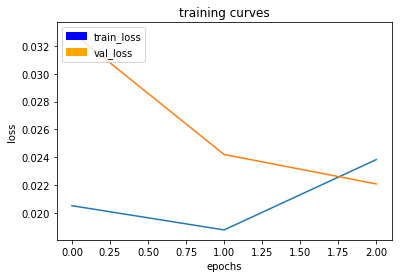

200/200 [==============================] - 181s - loss: 0.0238 - val_loss: 0.0221
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0191

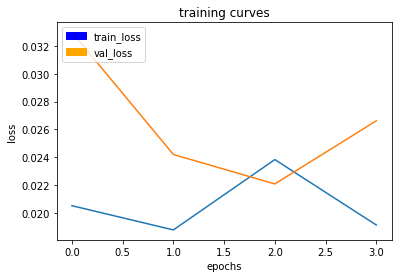

200/200 [==============================] - 181s - loss: 0.0191 - val_loss: 0.0266
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

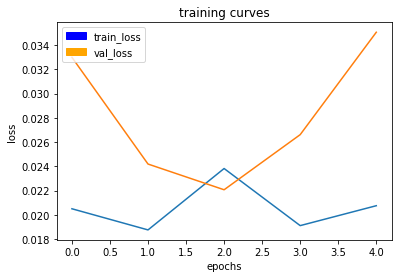

200/200 [==============================] - 181s - loss: 0.0208 - val_loss: 0.0351
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

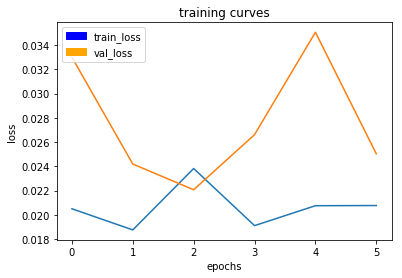

200/200 [==============================] - 181s - loss: 0.0207 - val_loss: 0.0250
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0187

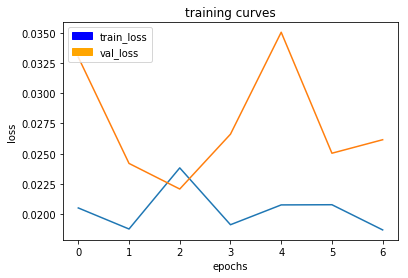

200/200 [==============================] - 181s - loss: 0.0187 - val_loss: 0.0262
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0208

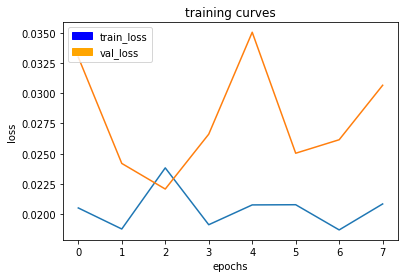

200/200 [==============================] - 181s - loss: 0.0209 - val_loss: 0.0307
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0205

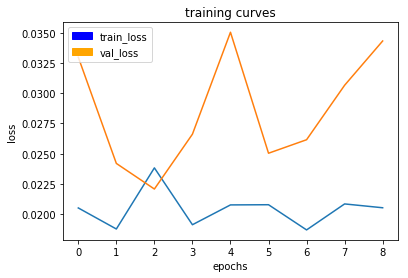

200/200 [==============================] - 181s - loss: 0.0205 - val_loss: 0.0343
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0189

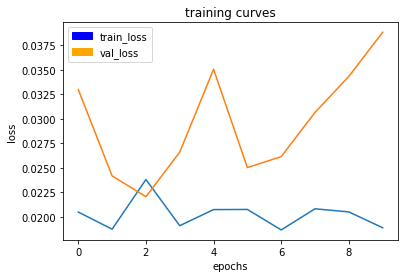

200/200 [==============================] - 181s - loss: 0.0189 - val_loss: 0.0388
run: 19, epochs: 190
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954179596722333
average intersection over union for other people is 0.3348651353860669
average intersection over union for the hero is 0.8570281625264794
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.984824234025608
average intersection over union for other people is 0.6941171940888891
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 62, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960076664417257
average intersection over union for other peopl

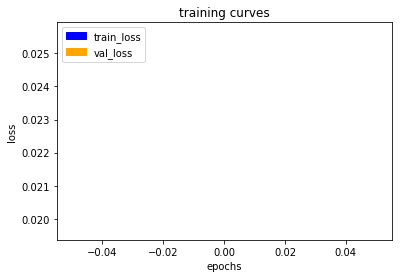

200/200 [==============================] - 183s - loss: 0.0197 - val_loss: 0.0256
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0211

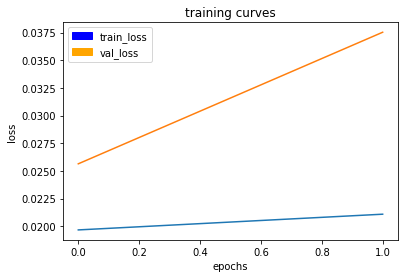

200/200 [==============================] - 181s - loss: 0.0211 - val_loss: 0.0375
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0197

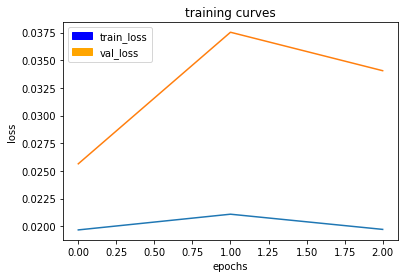

200/200 [==============================] - 181s - loss: 0.0197 - val_loss: 0.0341
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0215

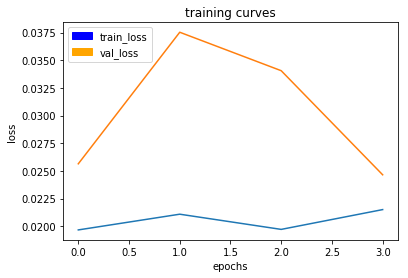

200/200 [==============================] - 181s - loss: 0.0215 - val_loss: 0.0246
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0209

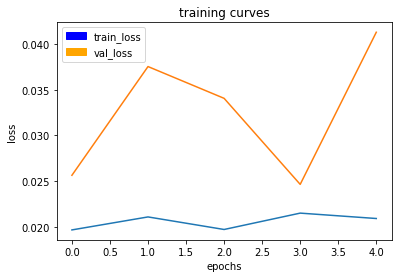

200/200 [==============================] - 181s - loss: 0.0209 - val_loss: 0.0413
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0206

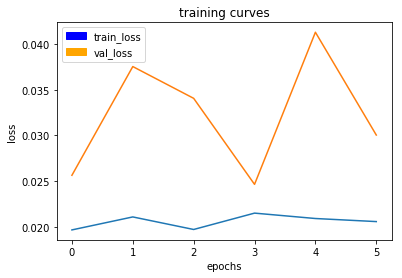

200/200 [==============================] - 180s - loss: 0.0205 - val_loss: 0.0300
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0187

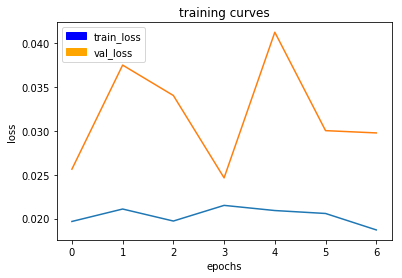

200/200 [==============================] - 181s - loss: 0.0187 - val_loss: 0.0298
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0203

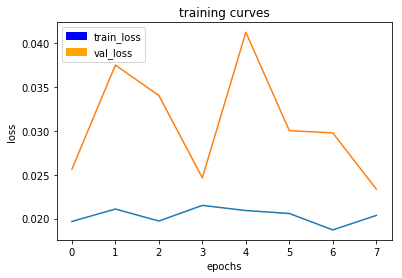

200/200 [==============================] - 181s - loss: 0.0203 - val_loss: 0.0234
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0191

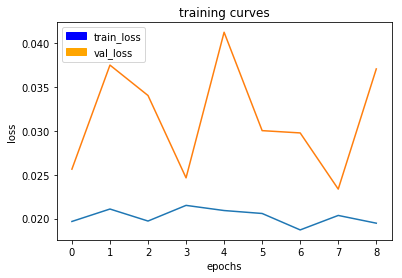

200/200 [==============================] - 181s - loss: 0.0195 - val_loss: 0.0371
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0192

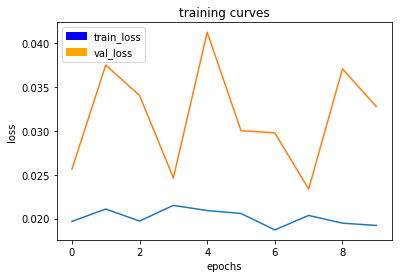

200/200 [==============================] - 181s - loss: 0.0192 - val_loss: 0.0328
run: 20, epochs: 200
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.995019385507689
average intersection over union for other people is 0.3123514031296181
average intersection over union for the hero is 0.8822951142397326
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9796872854720736
average intersection over union for other people is 0.5702960054195544
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 96, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9957128802699046
average intersection over union for other peopl

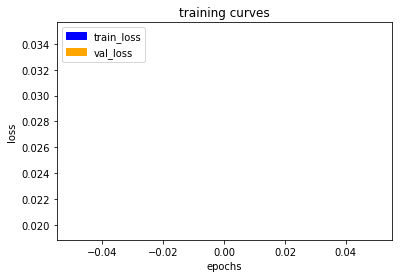

200/200 [==============================] - 183s - loss: 0.0196 - val_loss: 0.0349
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0202

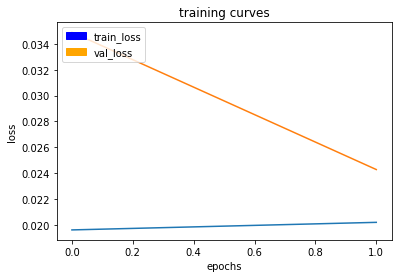

200/200 [==============================] - 181s - loss: 0.0202 - val_loss: 0.0243
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0202

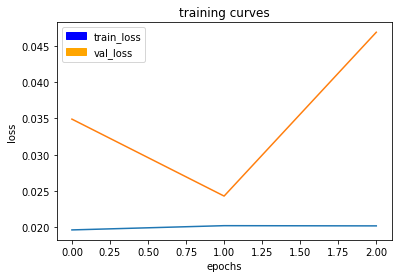

200/200 [==============================] - 181s - loss: 0.0202 - val_loss: 0.0469
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0205

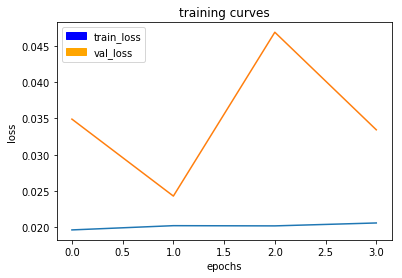

200/200 [==============================] - 181s - loss: 0.0205 - val_loss: 0.0334
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0197

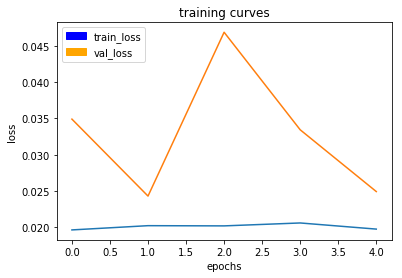

200/200 [==============================] - 181s - loss: 0.0197 - val_loss: 0.0249
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0205

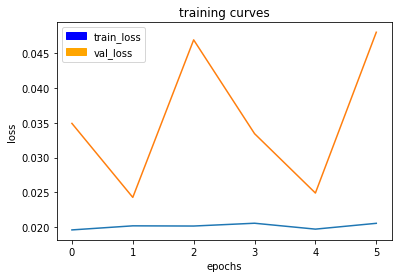

200/200 [==============================] - 181s - loss: 0.0205 - val_loss: 0.0480
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0201

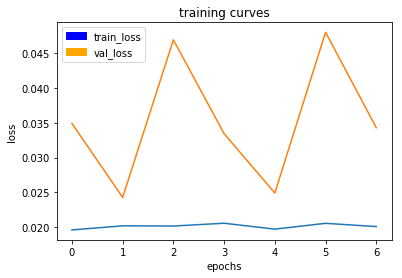

200/200 [==============================] - 181s - loss: 0.0201 - val_loss: 0.0343
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0188

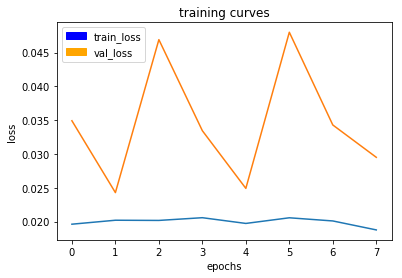

200/200 [==============================] - 181s - loss: 0.0188 - val_loss: 0.0295
Epoch 9/10
199/200 [============================>.] - ETA: 0s - loss: 0.0193

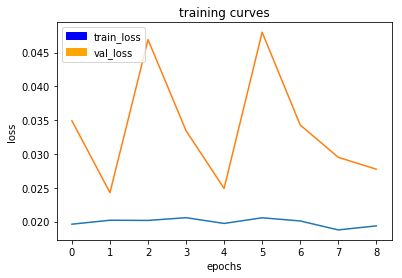

200/200 [==============================] - 181s - loss: 0.0194 - val_loss: 0.0277
Epoch 10/10
199/200 [============================>.] - ETA: 0s - loss: 0.0207

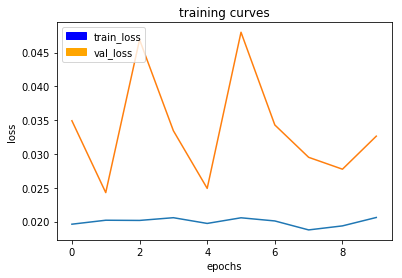

200/200 [==============================] - 181s - loss: 0.0206 - val_loss: 0.0326
run: 21, epochs: 210
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951974453656847
average intersection over union for other people is 0.31554185960656117
average intersection over union for the hero is 0.8336939280854894
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9824118542106469
average intersection over union for other people is 0.63384097380383
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 61, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959583839286237
average intersection over union for other peopl

In [22]:
weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)
for i in range(num_epoch_loop):
    if i > 0:
        weight_file_name = 'model_weights_%s' % i
        model = model_tools.load_network(weight_file_name)
    
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)   
    # Save your trained model weights
    weight_file_name = 'model_weights_%s' %(i+1)
    model_tools.save_network(model, weight_file_name)    
    
    
    run_num = 'run_%s' % (i+1)

    print("run: %s, epochs: %s" %((i+2), num_epochs * (i+2)))
    
    val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                            run_num,'patrol_with_targ', 'sample_evaluation_data') 

    val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                            run_num,'patrol_non_targ', 'sample_evaluation_data') 

    val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                            run_num,'following_images', 'sample_evaluation_data')
    
    # Scores for while the quad is following behind the target. 
    true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)
    
    # Scores for images while the quad is on patrol and the target is not visable
    true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)  

    # This score measures how well the neural network can detect the target from far away
    true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

    # Sum all the true positives, etc from the three datasets to get a weight for the score
    true_pos = true_pos1 + true_pos2 + true_pos3
    false_pos = false_pos1 + false_pos2 + false_pos3
    false_neg = false_neg1 + false_neg2 + false_neg3

    weight = true_pos/(true_pos+false_neg+false_pos)
    print(weight)

    # The IoU for the dataset that never includes the hero is excluded from grading
    final_IoU = (iou1 + iou3)/2
    print(final_IoU)

    # And the final grade score is 
    final_score = final_IoU * weight
    print(final_score)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [2]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights.h5'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [3]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

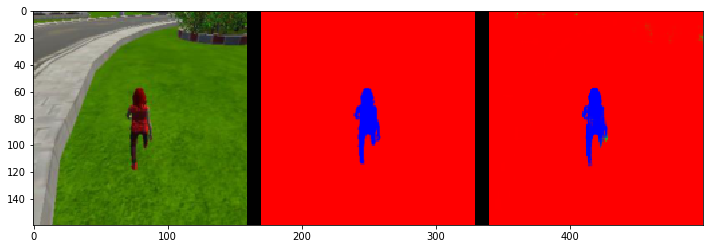

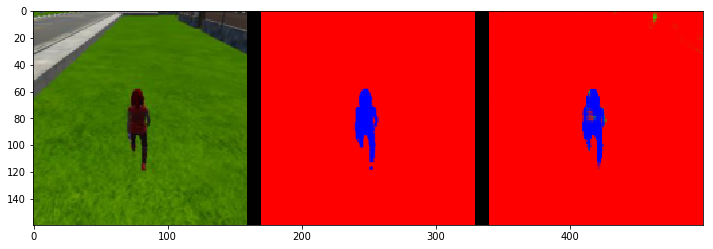

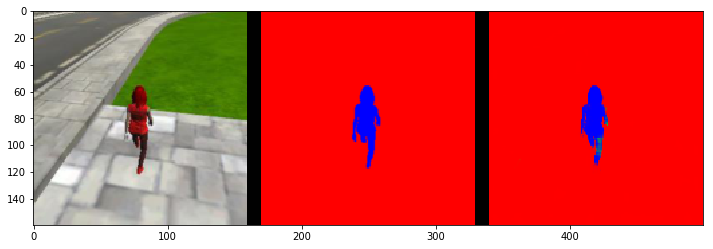

In [4]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

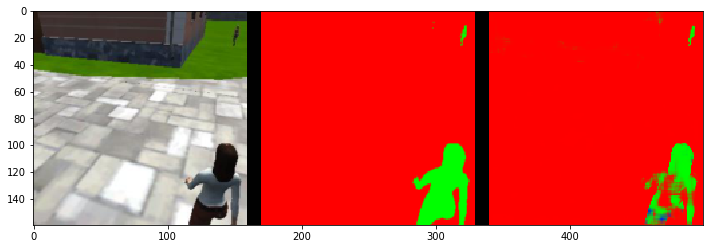

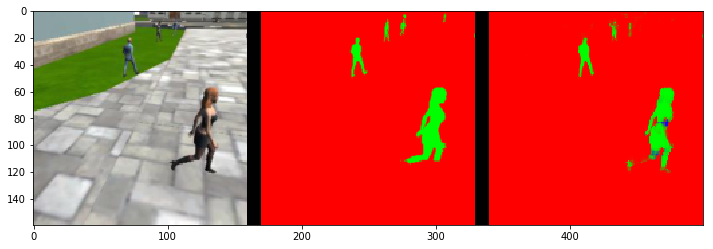

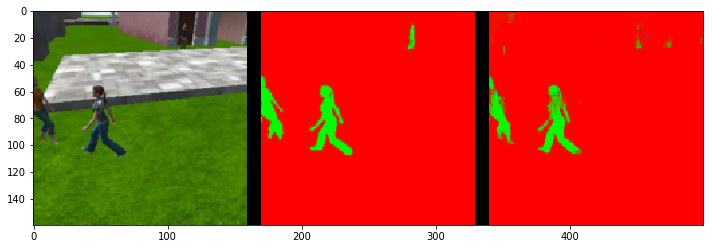

In [5]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

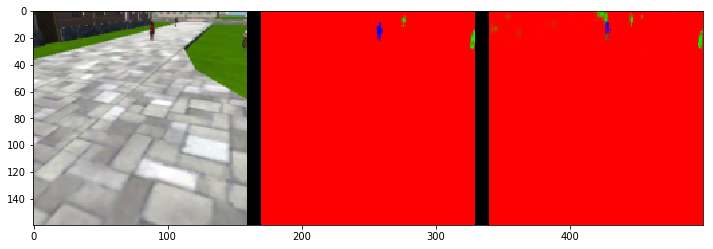

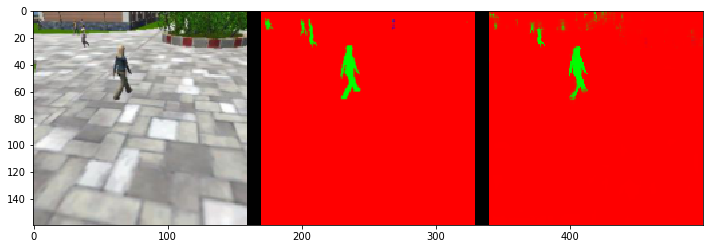

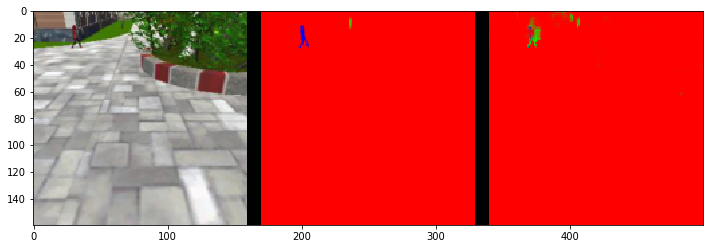

In [6]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [7]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9950274665684166
average intersection over union for other people is 0.3440170888448135
average intersection over union for the hero is 0.8767279086766692
number true positives: 539, number false positives: 0, number false negatives: 0


In [8]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9856213050711924
average intersection over union for other people is 0.7127213894910125
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 89, number false negatives: 0


In [9]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9958821322050833
average intersection over union for other people is 0.4416999808840458
average intersection over union for the hero is 0.263786649153968
number true positives: 172, number false positives: 2, number false negatives: 129


In [10]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7636949516648764


In [11]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5702572789153186


In [12]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.4355026050577782
